# Teil 1: Explorative Analyse

In diesem Abschnitt werden wir uns die Tabellen genauer ansehen, die die Daten zu den identifizierten Einflussfaktoren auf die Ausgaben für HzE enthalten. Wir werden eine univariate Analyse durchführen und wenn möglich auch eine bivariate Analyse, um die Daten besser zu verstehen und Einblicke zu gewinnen.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display
import warnings
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
#import missingno as msno

from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.ensemble import HistGradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score




warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

ModuleNotFoundError: No module named 'plotly'

In [ ]:


def exploratory_analysis(df, table_name):
    """Performs exploratory analysis on a DataFrame."""
    print(f"Explorative Analyse für die Tabelle '{table_name}':")
    
    # Beschreibung der Daten
    print("Beschreibung der Daten:")
    print("\n")
    print(df.describe())
    print("\n")
    # Beschreibung der Objekt-Spalten, falls vorhanden
    object_columns = df.select_dtypes(include='object').columns
    if not object_columns.empty:
        print(df.describe(include='object'))
        print("\n")
    # Anzahl der Datensätze
    print("Anzahl der Datensätze:", len(df))
    print("\n")
    
    # Spalteninformationen
    print("Spalteninformationen:")
    print(df.info())
    print("\n")
    
    # Anzahl der fehlenden Werte pro Spalte
    print("Anzahl der fehlenden Werte pro Spalte:")
    print(df.isnull().sum())
    print("\n")

    # Identifiziere und gib Duplikate aus
    print("Duplikate im DataFrame:")
    duplicates = df[df.duplicated()]
    print(duplicates)
    print("\n")
    
    # Einige erste und letzte Datensätze
    print("Einige erste Datensätze:")
    print(df.head())
    print("\n")
    print("Einige letzte Datensätze:")
    print(df.tail())
    print("\n")
  


### Verbindung zur SqlLite Datenbank erstellen und Tabellen aufrufen

In [ ]:

# Pfad zur SQLite-Datenbankdatei
db_file_path = './SoFinData_Datenbank_neu'

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect(db_file_path)

# Tabelle Bezirke abrufen
df_bezirke = pd.read_sql_query("SELECT * FROM Bezirke", conn)

# Query zum Laden der Daten aus den Tabellen
query_jugendeinwohner = """
SELECT j.Jahr, j.Bezirk as Bezirk_Nr, b.Name AS Bezirk_Name, j.Gesamt_Einwohner,j.Unter_18, j.Unter_21
FROM Jugendeinwohner j
JOIN Bezirke b ON j.Bezirk = b.Bezirk;
"""

query_Pauschale_Entgeltentwicklung= """
    SELECT *
    FROM Pauschale_Entgeltentwicklung AS p
"""

query_Mengen_Kostenetwicklung= """
    SELECT mke.Jahr,mke.Bezirk as Bezirk_Nr, mke.Level_1,mke.Level_2, mke.Level_3, mke.ProdNr, mke.ProdBez, mke.DirektKosten, mke.Menge,b.Name as Bezirk_Name
    FROM Mengen_Kosten_Entwicklung AS mke join Bezirke b on mke.Bezirk = b.Bezirk
"""

query_muk = """ 
SELECT muk.Jahr, muk.AggEbene, muk.Bezirk, muk.RP30a,b.Name as Bezirk_Name
FROM MUK_in_Bedarfsgemeinschaft_nach_SGBII muk join Bezirke b on muk.Bezirk = b.Bezirk
"""


# Daten in ein Pandas DataFrame Bezirk_Nameladen

df_jugendeinwohner = pd.read_sql_query(query_jugendeinwohner, conn)
# Neue Spalte für die Kombination von Bezirk_Nr und Bezirk_Name erstellen
df_jugendeinwohner['Bezirk_Nummer_Name'] = df_jugendeinwohner['Bezirk_Nr'].astype(str) + '-' + df_jugendeinwohner['Bezirk_Name']

df_Pauschale_Entgeltentwicklung = pd.read_sql_query(query_Pauschale_Entgeltentwicklung, conn)
# Prozentsätze in Dezimalzahlen umwandeln
df_Pauschale_Entgeltentwicklung['Zum_Vorjahr'] = df_Pauschale_Entgeltentwicklung['Zum_Vorjahr'].apply(lambda x: float(x.rstrip('%').replace(',', '.')) / 100 if x else None)
df_Pauschale_Entgeltentwicklung['Zu_2002'] = df_Pauschale_Entgeltentwicklung['Zu_2002'].apply(lambda x: float(x.rstrip('%').replace(',', '.')) / 100 if x else None)
df_Pauschale_Entgeltentwicklung['Zu_2006'] = df_Pauschale_Entgeltentwicklung['Zu_2006'].apply(lambda x: float(x.rstrip('%').replace(',', '.')) / 100 if x else None)
df_Pauschale_Entgeltentwicklung['Zu_2012'] = df_Pauschale_Entgeltentwicklung['Zu_2012'].apply(lambda x: float(x.rstrip('%').replace(',', '.')) / 100 if x else None)

df_Mengen_Kostenetwicklung = pd.read_sql_query(query_Mengen_Kostenetwicklung, conn)
# Neue Spalte für die Kombination von Bezirk_Nr und Bezirk_Name erstellen
df_Mengen_Kostenetwicklung['Bezirk_Nummer_Name'] = df_Mengen_Kostenetwicklung['Bezirk_Nr'].astype(str) + '-' + df_Mengen_Kostenetwicklung['Bezirk_Name']
df_Mengen_Kostenetwicklung['Prod_Nummer_Bez'] = df_Mengen_Kostenetwicklung['ProdNr'].astype(str) + ':' + df_Mengen_Kostenetwicklung['ProdBez']
df_muk = pd.read_sql_query(query_muk, conn)

df_muk['Bezirk_Nummer_Name'] = df_muk['Bezirk'].astype(str) + '-' + df_muk['Bezirk_Name']

### Analyse von Jugendeinwohner

Explorative Analyse für die Tabelle 'Jugendeinwohner':
Beschreibung der Daten:


         Jahr  Bezirk_Nr  Gesamt_Einwohner  Unter_18  Unter_21
count  132.00     132.00            132.00    132.00    132.00
mean  2017.00      36.50         306483.43  48182.99  56065.39
std      3.17       3.47          48338.32   8499.04   9533.89
min   2012.00      31.00         223305.00  33544.00  38193.00
25%   2014.00      33.75         266336.75  42740.25  49820.50
50%   2017.00      36.50         298734.00  45892.00  53523.50
75%   2020.00      39.25         340267.00  52873.00  61969.25
max   2022.00      42.00         420768.00  74344.00  84768.00


       Bezirk_Name Bezirk_Nummer_Name
count          132                132
unique          12                 12
top          Mitte           31-Mitte
freq            11                 11


Anzahl der Datensätze: 132


Spalteninformationen:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 7 columns):
 # 

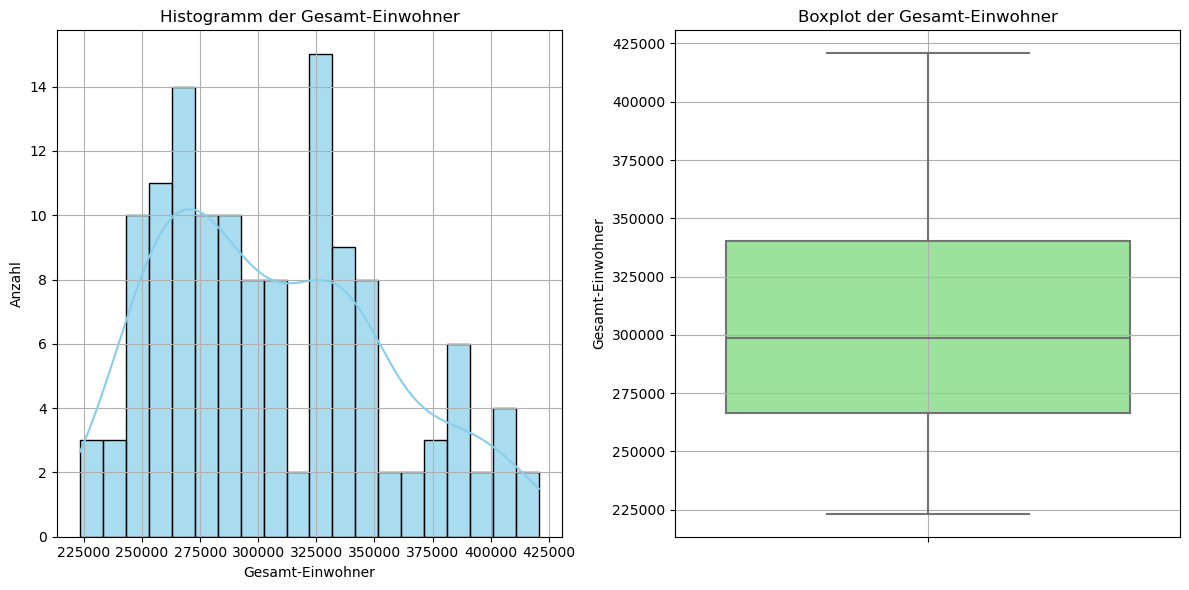

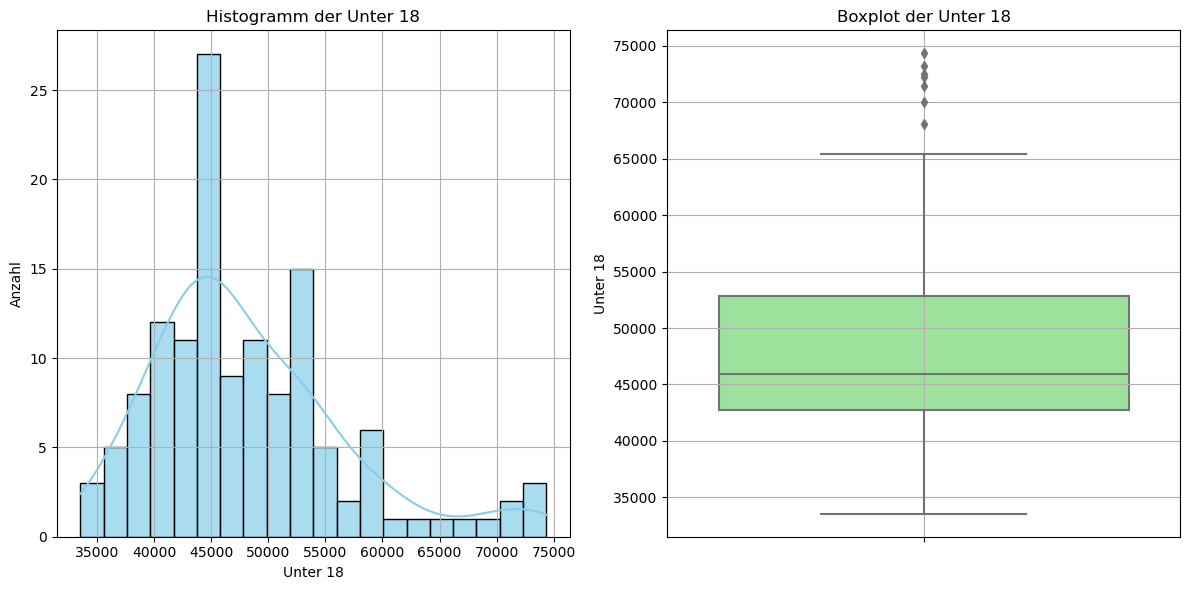

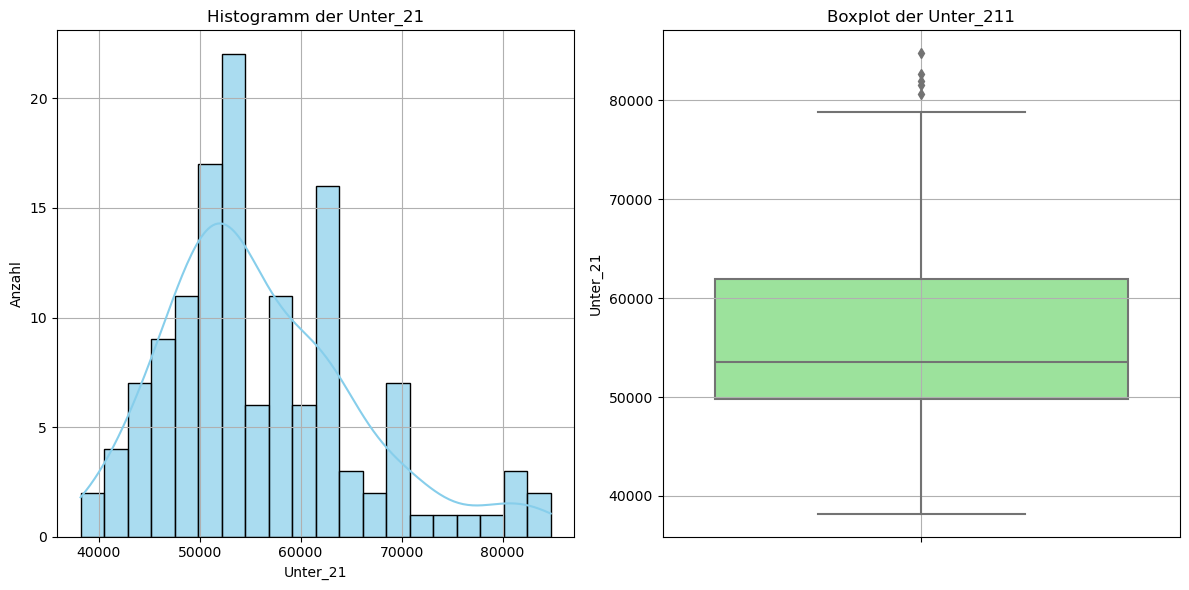

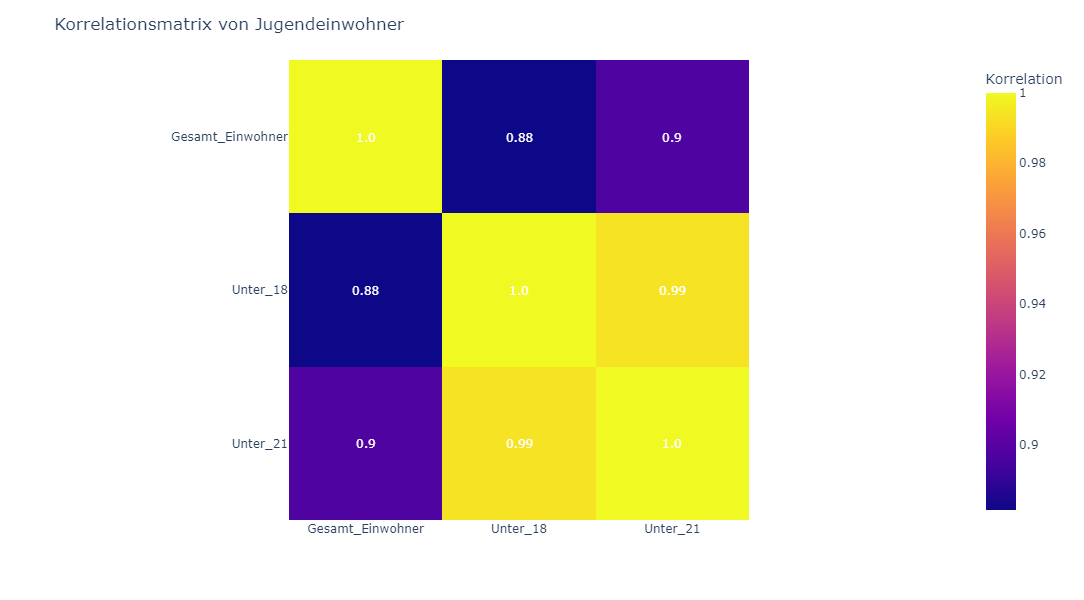

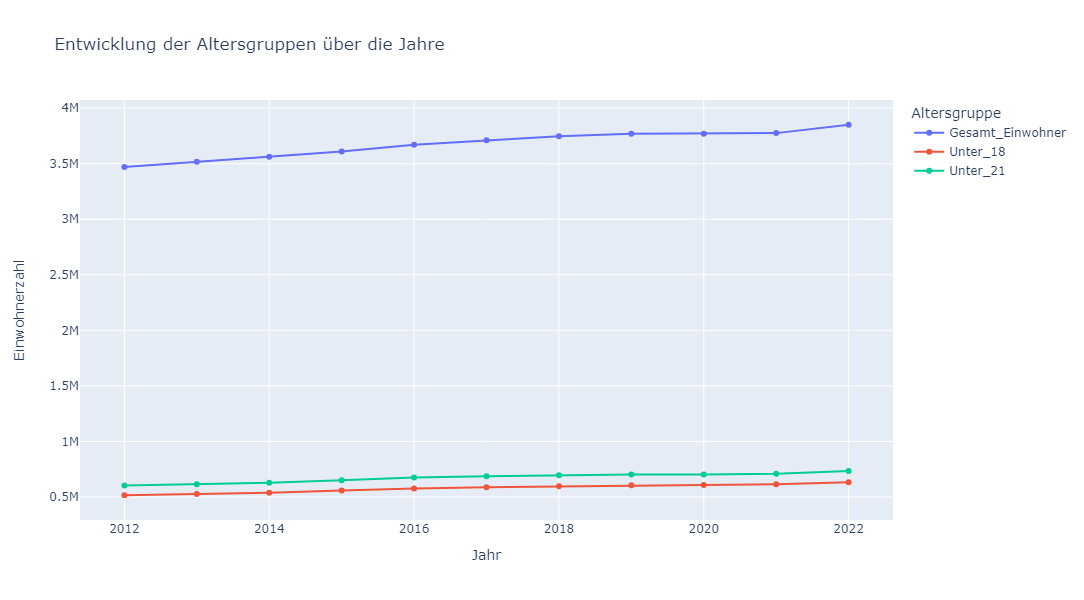

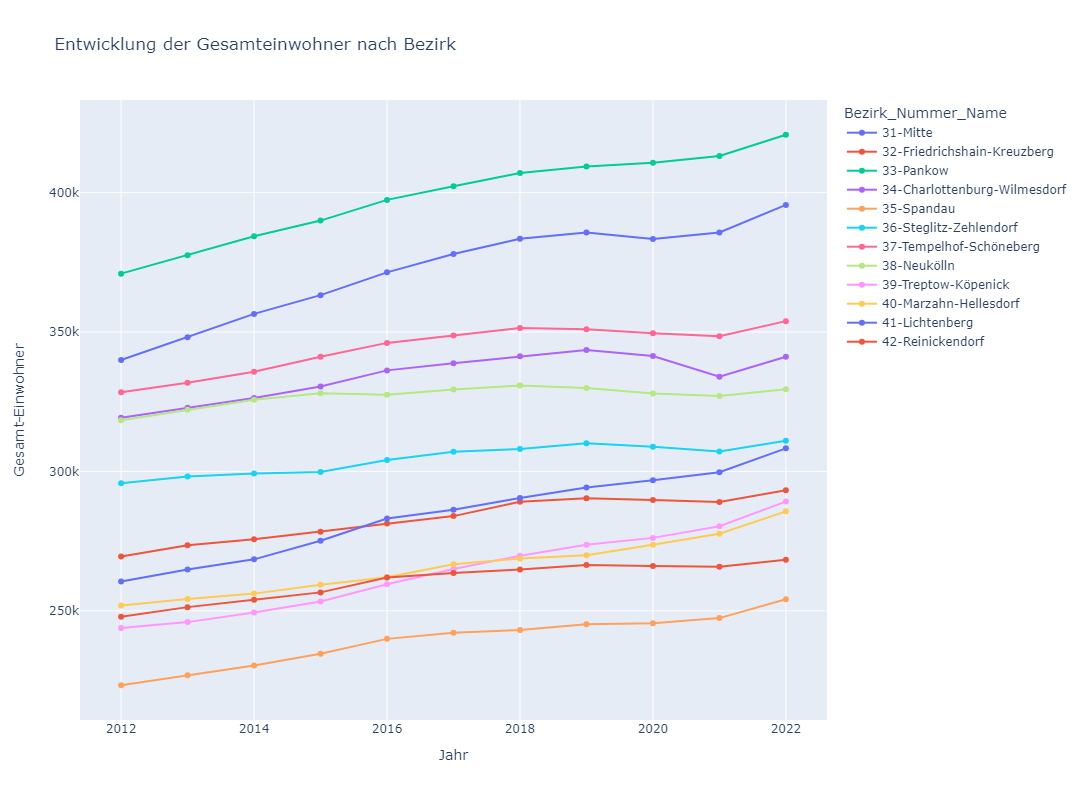

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Explorative Analyse durchführen

exploratory_analysis(df_jugendeinwohner, 'Jugendeinwohner')
# Histogramm und Boxplot für Gesamt_Einwohner
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df_jugendeinwohner, x='Gesamt_Einwohner', bins=20, kde=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogramm der Gesamt-Einwohner")
plt.xlabel("Gesamt-Einwohner")
plt.ylabel("Anzahl")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_jugendeinwohner, y='Gesamt_Einwohner', color='lightgreen')
plt.title("Boxplot der Gesamt-Einwohner")
plt.ylabel("Gesamt-Einwohner")
plt.grid(True)

plt.tight_layout()
plt.show()


    # Histogramm und Boxplot für Unter_18
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df_jugendeinwohner, x='Unter_18', bins=20, kde=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogramm der Unter 18")
plt.xlabel("Unter 18")
plt.ylabel("Anzahl")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_jugendeinwohner, y='Unter_18', color='lightgreen')
plt.title("Boxplot der Unter 18")
plt.ylabel("Unter 18")
plt.grid(True)

plt.tight_layout()
plt.show()

 # Histogramm und Boxplot für Unter_21
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df_jugendeinwohner, x='Unter_21', bins=20, kde=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogramm der Unter_21")
plt.xlabel("Unter_21")
plt.ylabel("Anzahl")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_jugendeinwohner, y='Unter_21', color='lightgreen')
plt.title("Boxplot der Unter_211")
plt.ylabel("Unter_21")
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

 # Korrelationsmatrix (nur für numerische Spalten, jedoch nicht für den Bezirk und das Jahr)

exclude_columns = ['Bezirk_Nr', 'Bezirk_Name', 'Jahr']
numeric_columns_df_jugendeinwohner = df_jugendeinwohner.select_dtypes(include=['int64', 'float64']).columns.difference(exclude_columns)

# Überprüfen, ob es mindestens eine numerische Spalte gibt
if len(numeric_columns_df_jugendeinwohner) > 0:
    # Berechnen der Korrelationsmatrix für numerische Spalten
    corr_matrix = df_jugendeinwohner[numeric_columns_df_jugendeinwohner].corr()
    
    # Plot der interaktiven Korrelationsmatrix mit plotly
    fig = px.imshow(corr_matrix, labels=dict(color="Korrelation"), x=corr_matrix.index, y=corr_matrix.columns)
    
    # Hinzufügen der Korrelationskoeffizienten als Annotations
    annotations = []
    for i, row in enumerate(corr_matrix.index):
        for j, col in enumerate(corr_matrix.columns):
            annotations.append(dict(text=str(round(corr_matrix.iloc[i, j], 2)),
                                    x=col, y=row,
                                    xref='x1', yref='y1',
                                    font=dict(color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black'),
                                    showarrow=False))
    fig.update_layout(title="Korrelationsmatrix von Jugendeinwohner", width=800, height=600, annotations=annotations)
    fig.show()
else:
    # Falls keine numerischen Spalten vorhanden sind, geben Sie eine entsprechende Nachricht aus
    print("Keine numerischen Spalten vorhanden, daher keine Korrelationsmatrix verfügbar.")

# Diagramm: Beziehung zwischen Jahr und Einwohner

df_plot = df_jugendeinwohner.groupby('Jahr').sum().reset_index()

# Plot der interaktiven Linien
fig = px.line(df_plot, x='Jahr', y=['Gesamt_Einwohner', 'Unter_18', 'Unter_21'], 
              title='Entwicklung der Altersgruppen über die Jahre',
              labels={'value': 'Einwohnerzahl', 'Jahr': 'Jahr', 'variable': 'Altersgruppe'},
              markers=True,  # Markierungen hinzufügen
              width=1000, height=600)  # Größe anpassen
fig.update_traces(mode='markers+lines')  # Modus auf Linien und Markierungen setzen
fig.show()



# Interaktive Visualisierung der Einwohnerentwicklung für jeden Bezirk
fig = px.line(df_jugendeinwohner, x='Jahr', y='Gesamt_Einwohner', color='Bezirk_Nummer_Name',
              title='Entwicklung der Gesamteinwohner nach Bezirk', markers=True)
fig.update_layout(
    width=1200,  # Breite in Pixeln
    height=800,  # Höhe in Pixeln
    xaxis_title='Jahr',
    yaxis_title='Gesamt-Einwohner'
)
fig.show()


   # Erstellen einer Dash-Anwendung
app = dash.Dash(__name__)

# Dropdown-Menü für die Auswahl eines Bezirks erstellen
bezirke_dropdown_options = [{'label': bezirk, 'value': bezirk} for bezirk in df_jugendeinwohner['Bezirk_Nummer_Name'].unique()]
bezirk_dropdown = dcc.Dropdown(id='bezirk-dropdown',
                               options=bezirke_dropdown_options,
                               value=df_jugendeinwohner['Bezirk_Nummer_Name'].iloc[0])

# Interaktive Anzeige erstellen
app.layout = html.Div([
    html.H2(children="Entwicklung der Einwohner nach Bezirk und Altersgruppen",style={'textAlign':'center'}),
    html.Div([
        html.Label("Bezirk auswählen:"),
        bezirk_dropdown
    ]),
    dcc.Graph(id='plots')
])

# Callback-Funktion für die Aktualisierung der Diagramme basierend auf der Auswahl im Dropdown-Menü
@app.callback(
    Output('plots', 'figure'),
    [Input('bezirk-dropdown', 'value')]
)
def update_plots(selected_bezirk):
    # Filtern der Daten basierend auf dem ausgewählten Bezirk
    filtered_df = df_jugendeinwohner[df_jugendeinwohner['Bezirk_Nummer_Name'] == selected_bezirk]
    
    # Diagramme erstellen
    fig1 = px.line(filtered_df, x='Jahr', y='Gesamt_Einwohner', title='Gesamteinwohner je Bezirk über die Zeit')
    fig2 = px.line(filtered_df, x='Jahr', y='Unter_18', title='Altersgruppen Unter_18 je Bezirk über die Zeit')
    fig3 = px.line(filtered_df, x='Jahr', y='Unter_21', title='Altersgruppen Unter_21 je Bezirk über die Zeit')
    
    # Subplots erstellen
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("Gesamteinwohner ", "Altersgruppe Unter_18", "Altersgruppe Unter_21 "))
    fig.add_trace(fig1.data[0], row=1, col=1)
    fig.add_trace(fig2.data[0], row=2, col=1)
    fig.add_trace(fig3.data[0], row=3, col=1)
    
    
    return fig

# Anwendung ausführen
if __name__ == '__main__':
    app.run_server(debug=True, port=8050)


### Analyse von Pauschale Entwicklung

Explorative Analyse für die Tabelle 'Pauschale_Entgeltentwicklung':
Beschreibung der Daten:


         Jahr  Zum_Vorjahr  Zu_2002  Zu_2006  Zu_2012
count   63.00        60.00    60.00    48.00    33.00
mean  2012.00         0.01     0.06     0.16     0.13
std      6.10         0.02     0.12     0.13     0.10
min   2002.00        -0.03    -0.06     0.00     0.00
25%   2007.00         0.00    -0.03     0.04     0.05
50%   2012.00         0.02     0.01     0.13     0.11
75%   2017.00         0.02     0.12     0.25     0.23
max   2022.00         0.06     0.33     0.42     0.33


         Level
count       63
unique       3
top     gesamt
freq        21


Anzahl der Datensätze: 63


Spalteninformationen:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Jahr         63 non-null     int64  
 1   Level        63 non-null     object 
 2   Zum_Vorjahr  60 

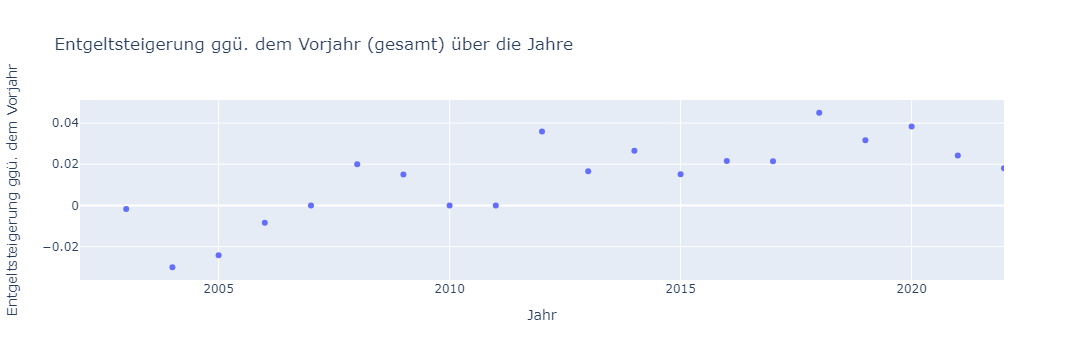

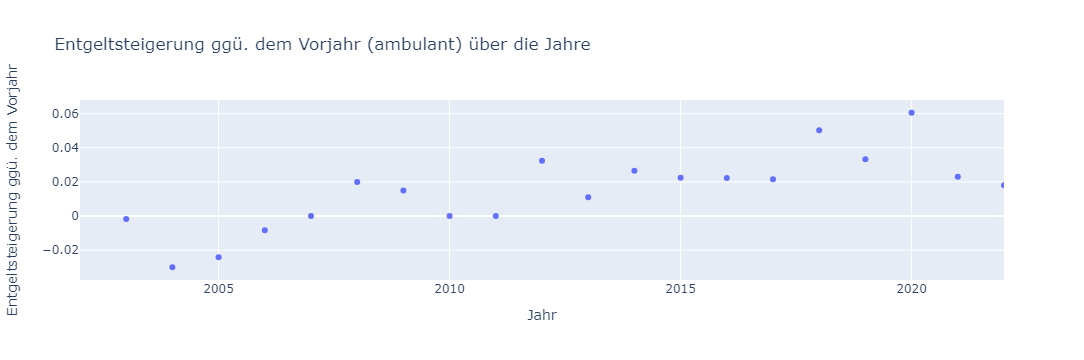

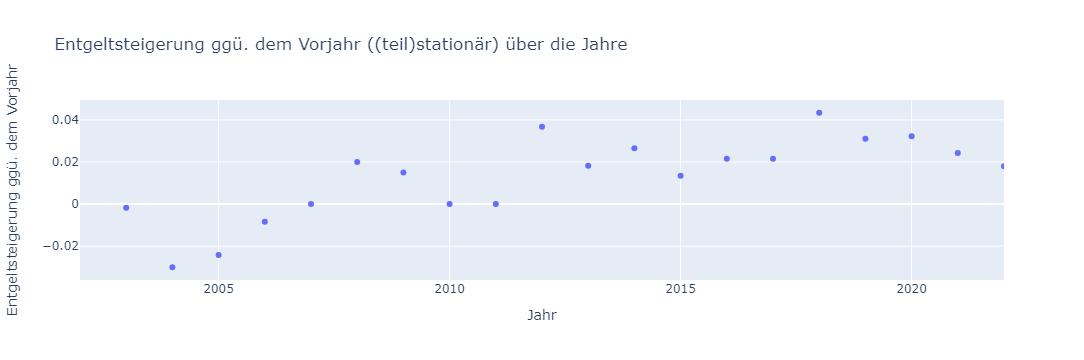

In [ ]:
# Explorative Analyse durchführen
exploratory_analysis(df_Pauschale_Entgeltentwicklung, 'Pauschale_Entgeltentwicklung')

# Plotting (Beispiel mit einem Streudiagramm)
# Eine Liste der einzigartigen Werte in der Spalte "Level" erhalten
levels = df_Pauschale_Entgeltentwicklung['Level'].unique()

# Eine Liste der einzigartigen Werte in der Spalte "Level" erhalten
levels = df_Pauschale_Entgeltentwicklung['Level'].unique()

# Für jeden einzigartigen Wert in der Spalte "Level" ein separates Diagramm erstellen
for level in levels:
    # Daten für das aktuelle Level filtern
    df_level = df_Pauschale_Entgeltentwicklung[df_Pauschale_Entgeltentwicklung['Level'] == level]
    
    # Diagramm für das aktuelle Level erstellen
    fig = px.scatter(df_level, x='Jahr', y='Zum_Vorjahr',
                     title=f"Entgeltsteigerung ggü. dem Vorjahr ({level}) über die Jahre",
                     labels={'Jahr': 'Jahr', 'Zum_Vorjahr': 'Entgeltsteigerung ggü. dem Vorjahr'})
    
    # x-Achsenbereich auf alle Jahre festlegen
    fig.update_layout(xaxis=dict(range=[df_Pauschale_Entgeltentwicklung['Jahr'].min(), df_Pauschale_Entgeltentwicklung['Jahr'].max()]))
    
    # Diagramm anzeigen
    fig.show()

### Analyse von Mengenen- und Kostenentwicklung

Explorative Analyse für die Tabelle 'Mengen_Kosten_Entwicklung':
Beschreibung der Daten:


         Jahr  Bezirk_Nr  DirektKosten   Menge
count 3456.00    3456.00       3456.00 3456.00
mean  2016.06      36.50    2000932.11 1145.60
std      3.79       3.45    2423778.77 1355.62
min   2010.00      31.00          0.00    0.00
25%   2013.00      33.75     374186.63  213.00
50%   2016.00      36.50    1185984.71  641.00
75%   2019.00      39.25    2894582.45 1530.75
max   2022.00      42.00   30974563.68 7755.00


       Level_1    Level_2 Level_3  ProdNr                   ProdBez  \
count     3456       3456    3456    3456                      3456   
unique       3          5       4      45                        47   
top        HzE  stationär     n/a   80172  T-Ambul.Eingliederh.-KJH   
freq      2712       1620    1836     156                       156   

       Bezirk_Name Bezirk_Nummer_Name                 Prod_Nummer_Bez  
count         3456               3456                   

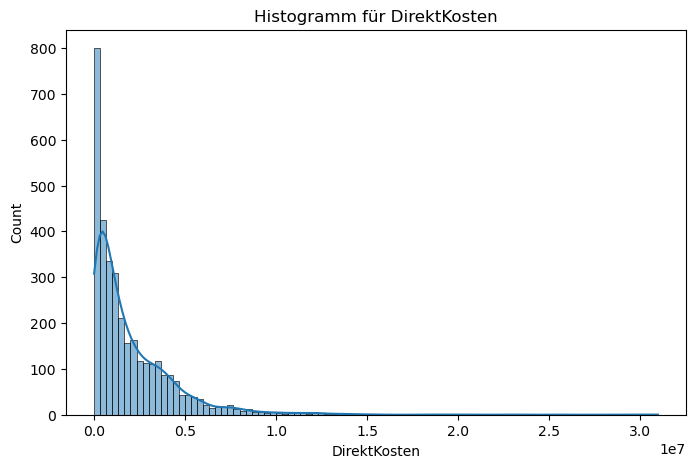

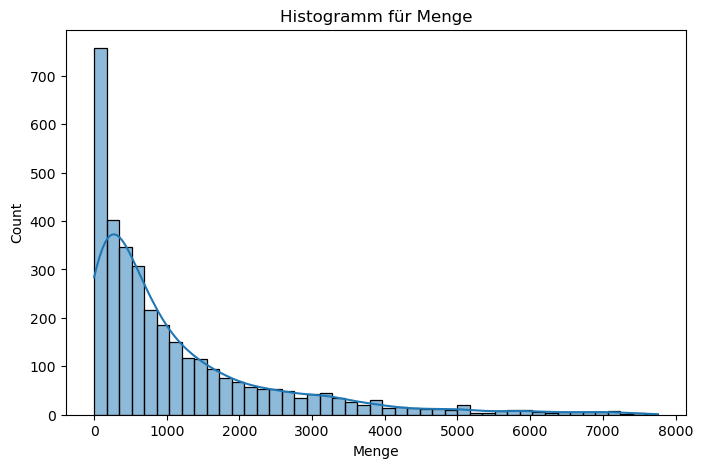

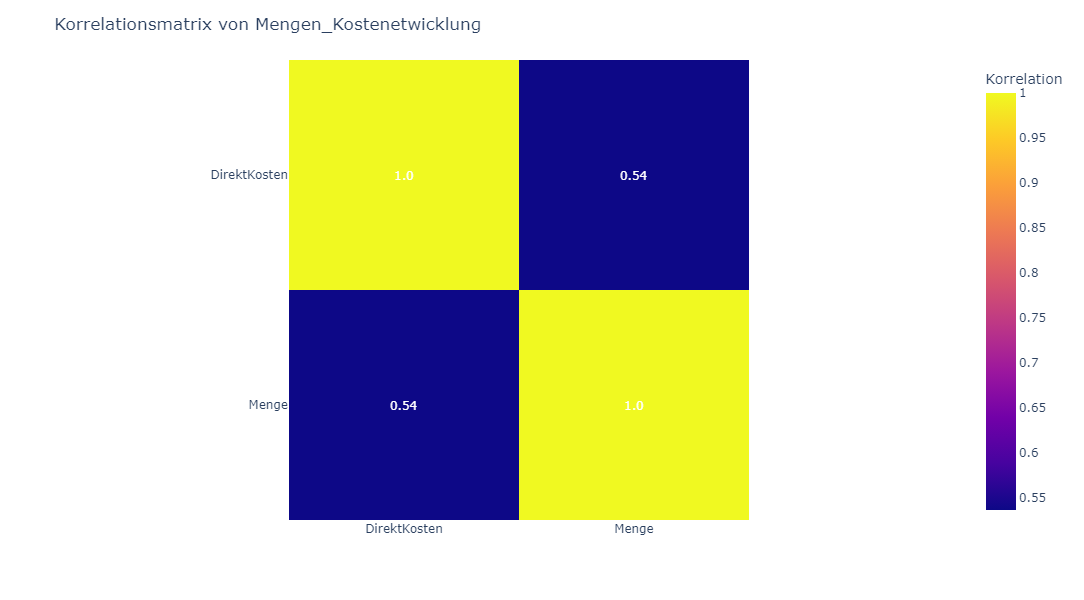

In [ ]:
# Explorative Analyse durchführen
df_Mengen_Kostenetwicklung.replace([np.inf, -np.inf], np.nan, inplace=True)
exploratory_analysis(df_Mengen_Kostenetwicklung, 'Mengen_Kosten_Entwicklung')

#Verteilungsanalyse
exclude_columns = [ 'Jahr', 'Bezirk_Nr']
numerische_spalten = df_Mengen_Kostenetwicklung.select_dtypes(include=['float64', 'int64']).columns.difference(exclude_columns)
for spalte in numerische_spalten:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df_Mengen_Kostenetwicklung, x=spalte, kde=True)
    plt.title(f"Histogramm für {spalte}")
    plt.show()

 # Korrelationsmatrix (nur für numerische Spalten, jedoch nicht für den Bezirk und das Jahr)

exclude_columns = ['Level_1', 'Level_1', 'Jahr', 'Level_2','Level_3','ProdNr','ProdBez','Bezirk_Nr']
numeric_columns_df_Mengen_Kostenetwicklung = df_Mengen_Kostenetwicklung.select_dtypes(include=['int64', 'float64']).columns.difference(exclude_columns)

# Überprüfen, ob es mindestens eine numerische Spalte gibt
if len(numeric_columns_df_Mengen_Kostenetwicklung) > 0:
    # Berechnen der Korrelationsmatrix für numerische Spalten
    corr_matrix = df_Mengen_Kostenetwicklung[numeric_columns_df_Mengen_Kostenetwicklung].corr()
    
    # Plot der interaktiven Korrelationsmatrix mit plotly
    fig = px.imshow(corr_matrix, labels=dict(color="Korrelation"), x=corr_matrix.index, y=corr_matrix.columns)
    
    # Hinzufügen der Korrelationskoeffizienten als Annotations
    annotations = []
    for i, row in enumerate(corr_matrix.index):
        for j, col in enumerate(corr_matrix.columns):
            annotations.append(dict(text=str(round(corr_matrix.iloc[i, j], 2)),
                                    x=col, y=row,
                                    xref='x1', yref='y1',
                                    font=dict(color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black'),
                                    showarrow=False))
    fig.update_layout(title="Korrelationsmatrix von Mengen_Kostenetwicklung", width=800, height=600, annotations=annotations)
    fig.show()
else:
    # Falls keine numerischen Spalten vorhanden sind, geben Sie eine entsprechende Nachricht aus
    print("Keine numerischen Spalten vorhanden, daher keine Korrelationsmatrix verfügbar.")
    
# Initialisierung der Dash App
app = dash.Dash(__name__)

# Erstellen der Dropdown-Optionen für Jahr und Bezirk
jahr_options = [{'label': str(jahr), 'value': jahr} for jahr in df_Mengen_Kostenetwicklung['Jahr'].unique()]
bezirk_options = [{'label': bezirk, 'value': bezirk} for bezirk in df_Mengen_Kostenetwicklung['Bezirk_Nummer_Name'].unique()]

# Layout der Dash App
app.layout = html.Div([
    html.Label('Jahr auswählen:'),
    dcc.Dropdown(
        id='jahr-dropdown',
        options=jahr_options,
        value=str(jahr_options[0]['value'])  # Standardwert
    ),
    html.Label('Bezirk auswählen:'),
    dcc.Dropdown(
        id='bezirke-dropdown',
        options=bezirk_options,
        value=bezirk_options[0]['value']  # Standardwert
    ),
     dcc.Graph(id='boxplot-graph', style={'height': '800px', 'width': '1000px'})
])

# Callback-Funktion für das Aktualisieren des Boxplots basierend auf der Dropdown-Auswahl
@app.callback(
    Output('boxplot-graph', 'figure'),
    [Input('jahr-dropdown', 'value'),
     Input('bezirke-dropdown', 'value')]
)
def update_boxplot(selected_jahr, selected_bezirk):
    # Filtern des DataFrames basierend auf der Auswahl
    filtered_df = df_Mengen_Kostenetwicklung[
        (df_Mengen_Kostenetwicklung['Jahr'] == int(selected_jahr)) &
        (df_Mengen_Kostenetwicklung['Bezirk_Nummer_Name'] == selected_bezirk)
    ]
    
    # Auswahl der Spalten vom Typ "object" außer 'ProdBez' und 'Bezirk_Name'
    object_columns = filtered_df.select_dtypes(include='object').columns.difference(['ProdBez', 'Bezirk_Name'])
    
    # Erstellen der Boxplots für jede Kategorie in den ausgewählten Spalten
    fig = go.Figure()
    for column in object_columns:
        for category in filtered_df[column].unique():
            subset_df = filtered_df[filtered_df[column] == category]
            fig.add_trace(go.Box(y=subset_df['DirektKosten'], name=f'{column}={category}'))
    
    # Layout-Anpassungen
    fig.update_layout(title='Boxplot für Direktkosten nach Kategorie', xaxis_title='Kategorie', yaxis_title='Direktkosten')
    
    return fig

# Starten der Dash App
if __name__ == '__main__':
     app.run_server(debug=True, port=8051)



In [ ]:

# Initialisierung der Dash App
app = dash.Dash(__name__)

# Erstellen der Dropdown-Optionen für Bezirke und ProdNr
bezirk_options = [{'label': bezirk, 'value': bezirk} for bezirk in df_Mengen_Kostenetwicklung['Bezirk_Nummer_Name'].unique()]
prodnr_options = [{'label': prodnr, 'value': prodnr} for prodnr in df_Mengen_Kostenetwicklung['Prod_Nummer_Bez'].unique()]

# Layout der Dash App

app.layout = html.Div([
    html.Label('Bezirk auswählen:'),

    
    dcc.Dropdown(
        id='bezirk-dropdown',
        options=bezirk_options,
        value=bezirk_options[0]['value']  # Standardwert
    ),
    html.Label('ProdNr auswählen:'),
    dcc.Dropdown(
        id='prodnr-dropdown',
        options=prodnr_options,
        value=prodnr_options[0]['value']  # Standardwert
    ),
    dcc.Graph(id='menge-graph'),
    dcc.Graph(id='direktkosten-graph')
])

# Callback-Funktion für das Aktualisieren der Grafiken basierend auf der Dropdown-Auswahl
@app.callback(
    [Output('menge-graph', 'figure'),
     Output('direktkosten-graph', 'figure')],
    [Input('bezirk-dropdown', 'value'),
     Input('prodnr-dropdown', 'value')]
)
def update_graphs(selected_bezirk, selected_prodnr):
    # Filtern des DataFrames basierend auf der Auswahl
    filtered_df = df_Mengen_Kostenetwicklung[
        (df_Mengen_Kostenetwicklung['Bezirk_Nummer_Name'] == selected_bezirk) &
        (df_Mengen_Kostenetwicklung['Prod_Nummer_Bez'] == selected_prodnr)
    ]
    
    # Plotting der Menge und der Direktkosten
    fig_menge = px.line(filtered_df, x='Jahr', y='Menge', title='Entwicklung der Menge über die Jahre')
    fig_direktkosten = px.line(filtered_df, x='Jahr', y='DirektKosten', title='Entwicklung der Direktkosten über die Jahre')
    
    return fig_menge, fig_direktkosten

# Starten der Dash App
if __name__ == '__main__':
    app.run_server(debug=True, port=8052)



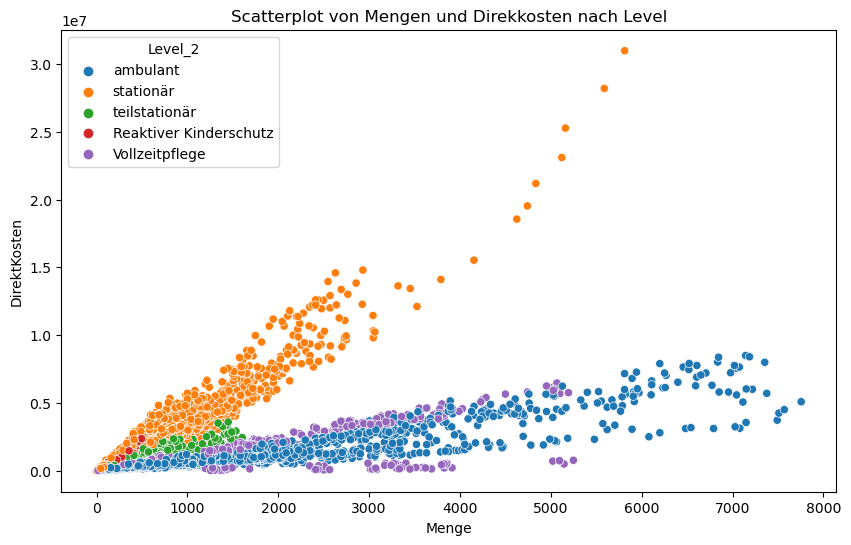

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_Mengen_Kostenetwicklung, x='Menge', y='DirektKosten', hue='Level_2')
plt.title("Scatterplot von Mengen und Direkkosten nach Level")
plt.show()

### Analyse von minderjährigen und unverheirateten Kinder (MUK)

Explorative Analyse für die Tabelle 'MUK_in_Bedarfsgemeinschaft_nach_SGBII':
Beschreibung der Daten:


         Jahr  AggEbene  Bezirk   RP30a
count  143.00    143.00  143.00  143.00
mean  2017.00      1.62   41.31 5734.03
std      3.17      2.14   17.04 2296.60
min   2012.00      1.00   31.00   87.00
25%   2014.00      1.00   34.00 4355.00
50%   2017.00      1.00   37.00 6202.00
75%   2020.00      1.00   40.00 7349.00
max   2022.00      9.00   99.00 9301.00


       Bezirk_Name Bezirk_Nummer_Name
count          143                143
unique          13                 13
top          Mitte           31-Mitte
freq            11                 11


Anzahl der Datensätze: 143


Spalteninformationen:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Jahr                143 non-null    int64 
 1   AggEbene            143 non-null    int

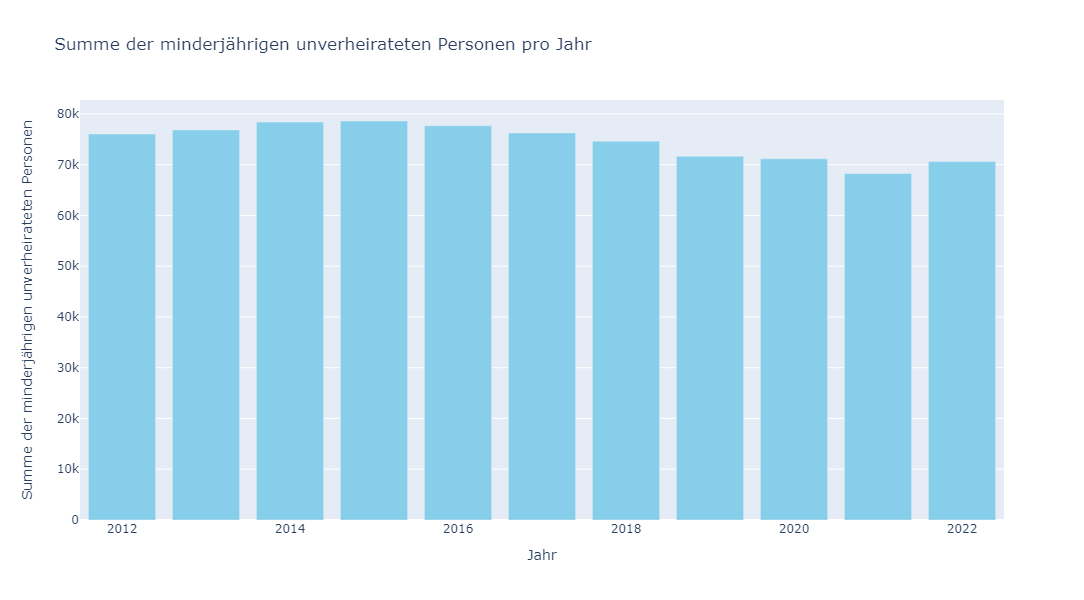

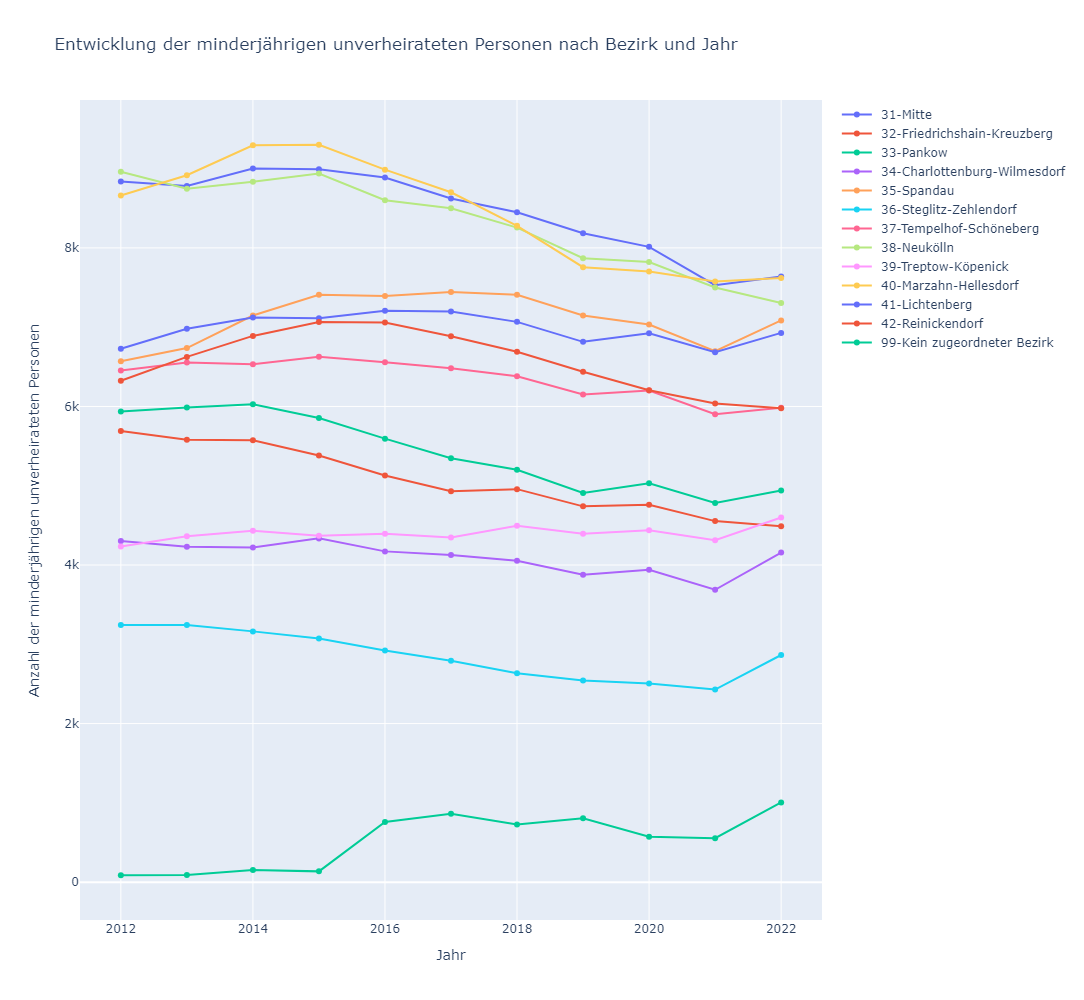

In [ ]:
# Explorative Analyse durchführen
exploratory_analysis(df_muk, 'MUK_in_Bedarfsgemeinschaft_nach_SGBII')

# Kumulative Summe der minderjährigen unverheirateten Personen für jedes Jahr berechnen
yearly_sum = df_muk.groupby('Jahr')['RP30a'].sum()

# Daten für das Balkendiagramm vorbereiten
data = go.Bar(
    x=yearly_sum.index,
    y=yearly_sum.values,
    marker=dict(color='skyblue')
)

# Layout für das Balkendiagramm festlegen
layout = go.Layout(
    title='Summe der minderjährigen unverheirateten Personen pro Jahr',
    xaxis=dict(title='Jahr'),
    yaxis=dict(title='Summe der minderjährigen unverheirateten Personen'),
    hovermode='closest',
    width=900,  # Breite des Diagramms
    height=600  # Höhe des Diagramms
)

# Das Balkendiagramm erstellen
fig = go.Figure(data=[data], layout=layout)

# Das Balkendiagramm anzeigen
fig.show()

# Alle einzigartigen Bezirke aus dem DataFrame extrahieren
unique_bezirke = df_muk['Bezirk_Nummer_Name'].unique()

data = []

for bezirk in unique_bezirke:
    df_bezirk = df_muk[df_muk['Bezirk_Nummer_Name'] == bezirk]
    trace = go.Scatter(
        x=df_bezirk['Jahr'],
        y=df_bezirk['RP30a'],
        mode='markers+lines',
        name=f' {bezirk}'
    )
    data.append(trace)

layout = go.Layout(
    title='Entwicklung der minderjährigen unverheirateten Personen nach Bezirk und Jahr',
    xaxis=dict(title='Jahr'),
    yaxis=dict(title='Anzahl der minderjährigen unverheirateten Personen'),
    hovermode='closest',
    width=1200,  # Breite des Diagramms
    height=1000  # Höhe des Diagramms
)

fig = go.Figure(data=data, layout=layout)

fig.show()


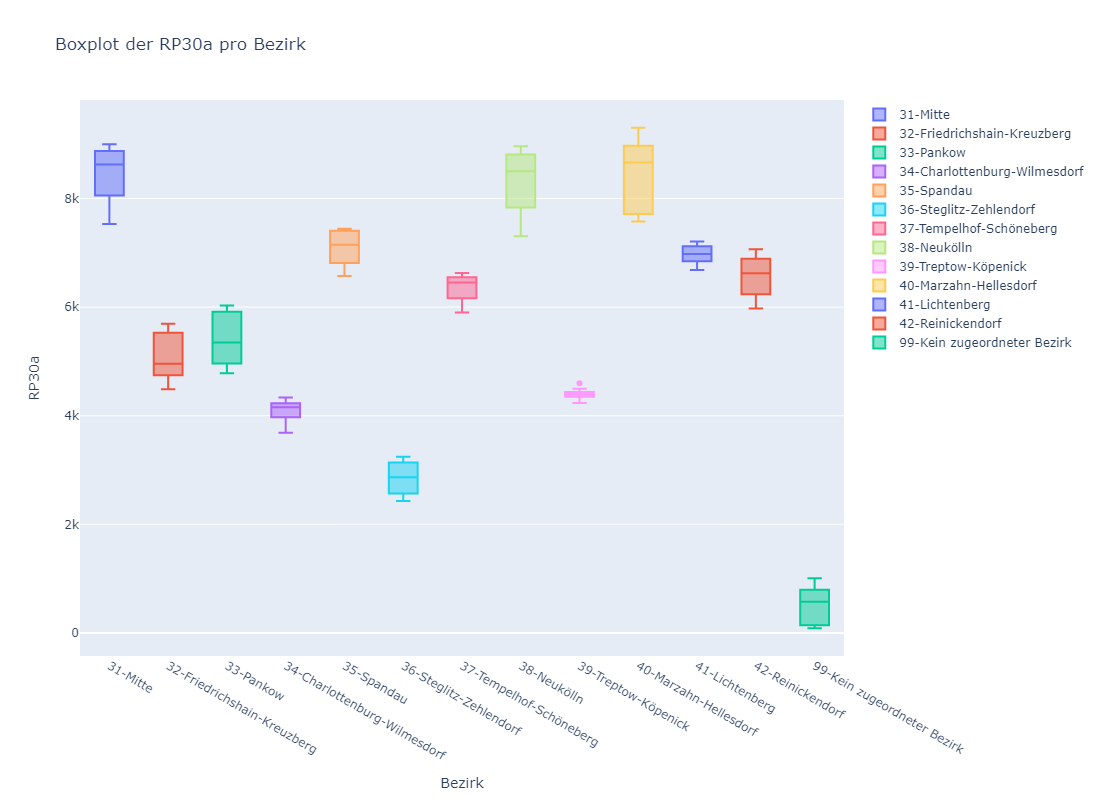

In [ ]:
# Boxplot erstellen
fig = go.Figure()

# Daten für jeden Bezirk hinzufügen
for bezirk in df_muk['Bezirk_Nummer_Name'].unique():
    bezirk_data = df_muk[df_muk['Bezirk_Nummer_Name'] == bezirk]['RP30a']
    fig.add_trace(go.Box(y=bezirk_data, name=bezirk))

# Layout für das Diagramm festlegen
fig.update_layout(
    title='Boxplot der RP30a pro Bezirk',
    xaxis=dict(title='Bezirk'),
    yaxis=dict(title='RP30a'),
    #boxmode='group',  # Gruppierung der Boxen nach Bezirk
    width=1000,  # Breite des Diagramms
    height=800  # Höhe des Diagramms
)

# Das Diagramm anzeigen
fig.show()

Es gibt auch Unterschiede in der Varianz zwischen den Bezirken.

### Analyse der zusammengeführten Daten

   Jahr  Bezirk Bezirk_Name       Level_1    Level_2  \
0  2010      31       Mitte  EGH SGB VIII   ambulant   
1  2010      31       Mitte  EGH SGB VIII   ambulant   
2  2010      31       Mitte  EGH SGB VIII   ambulant   
3  2010      31       Mitte  EGH SGB VIII  stationär   
4  2010      31       Mitte  EGH SGB VIII  stationär   

                       Level_3 ProdNr                   ProdBez  DirektKosten  \
0                          n/a  80172  T-Ambul.Eingliederh.-KJH    1113989.75   
1                          n/a  80172  T-Ambul.Eingliederh.-KJH    1113989.75   
2                          n/a  80172  T-Ambul.Eingliederh.-KJH    1113989.75   
3  inner- und außerhalb Berlin  80177   T-Stat.Eingliederh.-KJH    4903672.91   
4  inner- und außerhalb Berlin  80177   T-Stat.Eingliederh.-KJH    4903672.91   

   Menge  Gesamt_Einwohner  Unter_18  Unter_21  AggEbene  RP30a  \
0   2739               NaN       NaN       NaN       NaN    NaN   
1   2739               NaN       NaN      

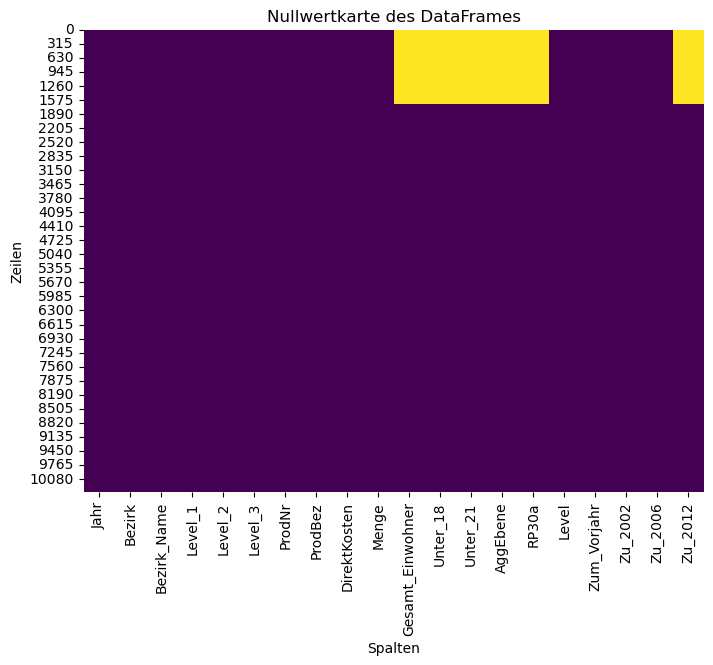

Jahr column missing values: 0
Bezirk column missing values: 0
Bezirk_Name column missing values: 0
Level_1 column missing values: 0
Level_2 column missing values: 0
Level_3 column missing values: 0
ProdNr column missing values: 0
ProdBez column missing values: 0
DirektKosten column missing values: 0
Menge column missing values: 0
Gesamt_Einwohner column missing values: 1656
Unter_18 column missing values: 1656
Unter_21 column missing values: 1656
AggEbene column missing values: 1656
RP30a column missing values: 1656
Level column missing values: 0
Zum_Vorjahr column missing values: 0
Zu_2002 column missing values: 0
Zu_2006 column missing values: 0
Zu_2012 column missing values: 1656




In [ ]:
# Query zur Zusammenführung der Daten aus allen Tabellen

query = """
    SELECT *
    FROM Mengen_Kosten_Entwicklung AS m
    JOIN Bezirke AS b ON m.Bezirk = b.Bezirk
    JOIN Pauschale_Entgeltentwicklung AS p ON m.Jahr = p.Jahr
    JOIN Jugendeinwohner AS j ON m.Jahr = j.Jahr AND m.Bezirk = j.Bezirk
    JOIN MUK_in_Bedarfsgemeinschaft_nach_SGBII AS muk ON m.Jahr = muk.Jahr AND m.Bezirk = muk.Bezirk
"""

query_AlleTabelleZusammen = """ 
select mke.Jahr, mke.Bezirk, b.Name as Bezirk_Name, mke.Level_1, mke.Level_2, mke.Level_3,mke.ProdNr, mke.ProdBez, mke.DirektKosten, mke.Menge,
j.Gesamt_Einwohner,j.Unter_18, j.Unter_21,
muk.AggEbene, muk.RP30a,
pe.Level,pe.Zum_Vorjahr, pe.Zu_2002, pe.Zu_2006, pe.Zu_2012
from Mengen_Kosten_Entwicklung  mke join Bezirke b on mke.Bezirk = b.Bezirk
left join Jugendeinwohner j on mke.Jahr = j.Jahr   and j.Bezirk = mke.Bezirk 
left join MUK_in_Bedarfsgemeinschaft_nach_SGBII muk on j.Jahr = muk.Jahr and j.Bezirk = muk.Bezirk
join Pauschale_Entgeltentwicklung pe on pe.jahr = mke.jahr
"""
#where mke.jahr>= 2012
# Daten ausführen und in ein DataFrame laden
df = pd.read_sql_query(query_AlleTabelleZusammen, conn)

# Prozentsätze in Dezimalzahlen umwandeln
df['Zum_Vorjahr'] = df['Zum_Vorjahr'].apply(lambda x: float(x.rstrip('%').replace(',', '.')) / 100 if x else None)
df['Zu_2002'] = df['Zu_2002'].apply(lambda x: float(x.rstrip('%').replace(',', '.')) / 100 if x else None)
df['Zu_2006'] = df['Zu_2006'].apply(lambda x: float(x.rstrip('%').replace(',', '.')) / 100 if x else None)
df['Zu_2012'] = df['Zu_2012'].apply(lambda x: float(x.rstrip('%').replace(',', '.')) / 100 if x else None)
#Bezirk_Nr_Name = df['Bezirk'].astype(str) + '-' + df_jugendeinwohner['Bezirk_Name']

# Anzeigen der ersten Zeilen des zusammengeführten DataFrames
print(df.head())

# Deskriptive Statistiken
basic_statistics = df.describe()
print(basic_statistics)
print("\n")
print(df.info())
print("\n")


# Nullwerte in DataFrame finden
null_values = df.isnull()

# Heatmap der Nullwerte erstellen
plt.figure(figsize=(8, 6))
sns.heatmap(null_values, cmap='viridis', cbar=False)
plt.title('Nullwertkarte des DataFrames')
plt.xlabel('Spalten')
plt.ylabel('Zeilen')
plt.show()

def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
display_missing(df)
# Nullwerte durch NaN ersetzen
df.fillna(value=np.nan, inplace=True)


Es fällt auf, dass die Spalten 0 bis 9 und 15 bis 19 jeweils 10368 non-null Werte aufweisen. Im Gegensatz dazu enthalten die Spalten 10 bis 14 nur 8712 Werte, was bedeutet, dass 1656 null-Werte vorliegen. Dieser Unterschied erklärt sich dadurch, dass die Tabelle, die unsere Zielvariable "DirektKosten" enthält, Daten ab dem Jahr 2010 enthält. Bei der Zusammenführung aller Tabellen in einer Tabelle werden daher die Spalten, die Daten erst ab späteren Jahren enthalten (wie Jugendeinwohner und MUK-Tabelle), mit Nullen befüllt.

In [ ]:
# Identifiziere und gib Duplikate aus
duplicates = df[df.duplicated()]
print("Duplikate im DataFrame:")
print(duplicates)

Duplikate im DataFrame:
Empty DataFrame
Columns: [Jahr, Bezirk, Bezirk_Name, Level_1, Level_2, Level_3, ProdNr, ProdBez, DirektKosten, Menge, Gesamt_Einwohner, Unter_18, Unter_21, AggEbene, RP30a, Level, Zum_Vorjahr, Zu_2002, Zu_2006, Zu_2012]
Index: []


#### Die Dataframe enthält keine Duplicates

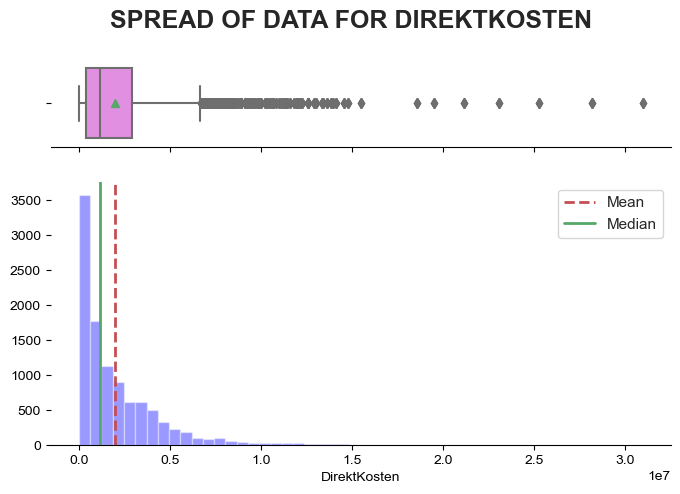

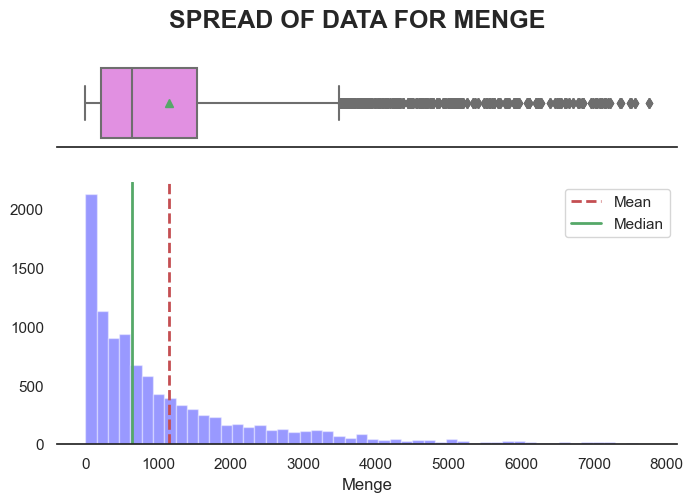

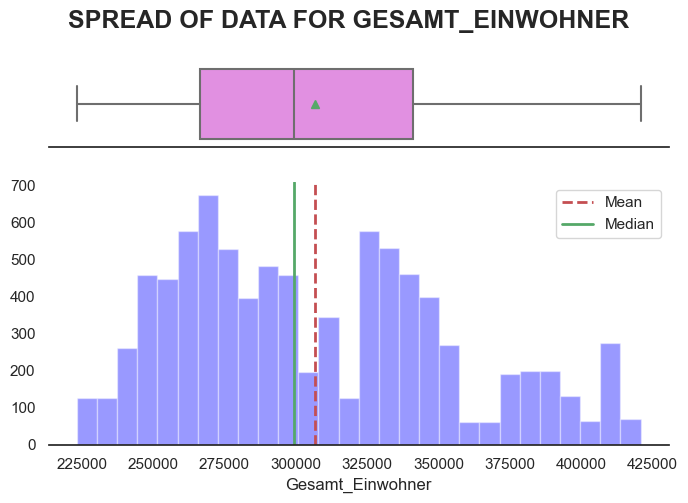

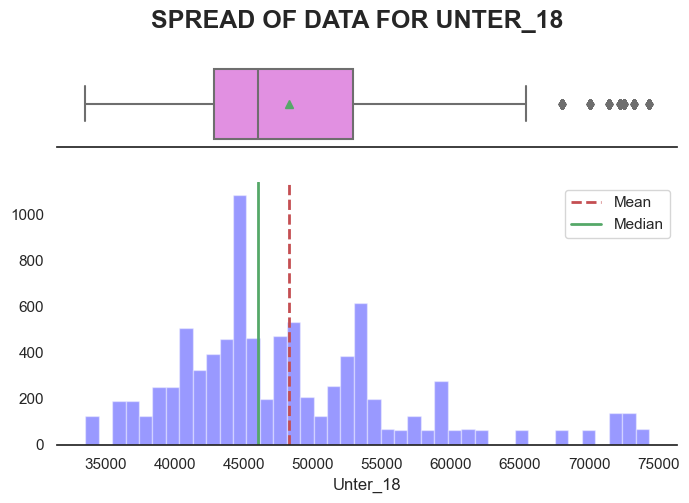

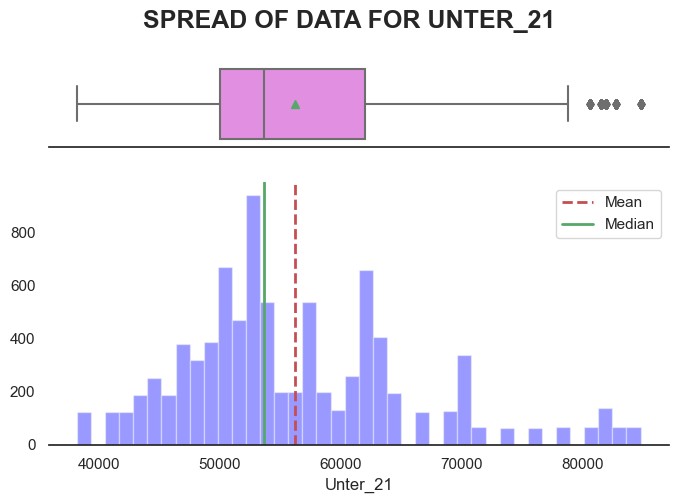

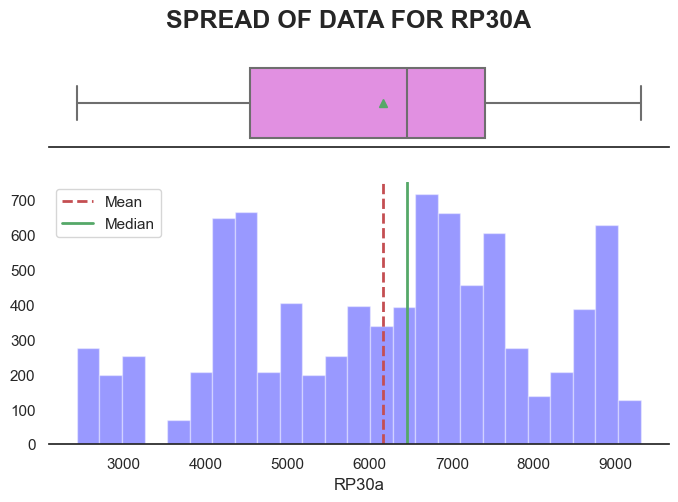

In [ ]:
def dist_box(data):
# Die Funktion erstellt ein kombiniertes Diagramm für die univariate Analyse einer kontinuierlichen Variablen, um die Streuung, die zentrale Tendenz, 
# die Streuung und Ausreißer zu überprüfen. 
    Name=data.name.upper()
    fig,(ax_box,ax_dis)  =plt.subplots(nrows=2,sharex=True,gridspec_kw = {"height_ratios": (.25, .75)},figsize=(8, 5))
    mean=data.mean()
    median=data.median()
    sns.set_theme(style="white")
    fig.suptitle("SPREAD OF DATA FOR "+ Name  , fontsize=18, fontweight='bold')
    sns.boxplot(x=data,showmeans=True, orient='h',color="violet",ax=ax_box)
    ax_box.set(xlabel='')
     # just trying to make visualisation better. This will set background to white
    sns.despine(top=True,right=True,left=True) # to remove side line from graph
    sns.distplot(data,kde=False,color='blue',ax=ax_dis)
    ax_dis.axvline(mean, color='r', linestyle='--',linewidth=2)
    ax_dis.axvline(median, color='g', linestyle='-',linewidth=2)
    plt.legend({'Mean':mean,'Median':median})


#select all quantitative columns for checking the spread
list_col=  ['DirektKosten','Menge','Gesamt_Einwohner','Unter_18','Unter_21','RP30a']
for i in range(len(list_col)):
    dist_box(df[list_col[i]])

### Datapreprocessing

#### Fixing der Datentypen
Die Spalten Bezirk, Bezirk_Name, Level_1, Level_2, Level_3, ProdNr, ProdBez, AggEbene und Level haben den Datentyp int/object/float. Wir können sie in den Kategorietyp ändern, um den benötigten Datenspeicherplatz zu reduzieren.

In [ ]:
df_proceed = df.copy()
#numerische varaible
numeric_columns_df_proceed = df_proceed.select_dtypes(include=['int64', 'float64'])
# converting categorical varaible to category type
category_col = ['Bezirk', 'Bezirk_Name','Level_1', 'Level_2', 'Level_3', 'ProdNr', 'ProdBez', 'AggEbene','Level']
df_proceed[category_col] = df_proceed[category_col].astype('category')

df_proceed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10368 entries, 0 to 10367
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Jahr              10368 non-null  int64   
 1   Bezirk            10368 non-null  category
 2   Bezirk_Name       10368 non-null  category
 3   Level_1           10368 non-null  category
 4   Level_2           10368 non-null  category
 5   Level_3           10368 non-null  category
 6   ProdNr            10368 non-null  category
 7   ProdBez           10368 non-null  category
 8   DirektKosten      10368 non-null  float64 
 9   Menge             10368 non-null  int64   
 10  Gesamt_Einwohner  8712 non-null   float64 
 11  Unter_18          8712 non-null   float64 
 12  Unter_21          8712 non-null   float64 
 13  AggEbene          8712 non-null   category
 14  RP30a             8712 non-null   float64 
 15  Level             10368 non-null  category
 16  Zum_Vorjahr       1036

Wir können sehen, dass der Speicherverbrauch von 1,6+ MB auf 986,6+ KB gesunken ist.

#### Imputation von fehlenden Werten

In [ ]:
colum_missing_values = ['Gesamt_Einwohner', 'Unter_18', 'Unter_21', 'RP30a', 'Zu_2012']

# Imputation fehlender Werte in numerischen Spalten mit dem Mittelwert
imputer = SimpleImputer(strategy='mean')
df_proceed[colum_missing_values] = imputer.fit_transform(df_proceed[colum_missing_values])

# Finde die seltenste Kategorie in der Spalte "AggEbene"
rarest_category = df_proceed['AggEbene'].value_counts().idxmin()

# Imputation fehlender Werte in der Spalte "AggEbene" mit der seltensten Kategorie
df_proceed['AggEbene'] = df_proceed['AggEbene'].fillna(rarest_category)

#### Kategorische Spalten in numerische Umwandeln

Jede kategoriale Variable 'feature' wird basierend auf dem Mittelwert der Zielvariablen 'DirektKosten' für jede Kategorie in numerische Werte codiert. Diese numerischen Werte repräsentieren die ordinale Rangfolge der Kategorien entsprechend ihren Mittelwerten der Zielvariablen. Normalerweise wird dafür One-Hot-Encoding verwendet. Aber die Verwendung von One-Hot-Encoding in diesem Fall würde die Dimension der Merkmale stark erhöhen, was die Möglichkeit von Überanpassungen erhöht.

In [ ]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'DirektKosten']].groupby(feature).mean()['DirektKosten']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
    # Lösche die ursprüngliche kategoriale Spalte
    frame.drop(columns=[feature], inplace=True)

cat_encoded = []
for c in category_col:  
    encode(df_proceed, c)
    cat_encoded.append(c+'_E')
print(cat_encoded)


['Bezirk_E', 'Bezirk_Name_E', 'Level_1_E', 'Level_2_E', 'Level_3_E', 'ProdNr_E', 'ProdBez_E', 'AggEbene_E', 'Level_E']


# Teil 2: Mulivariate Analyse der Daten

Um erkennen zu können, welche Attribute tatsächlich ausschlaggebend für die Vorhersage der Ausgaben zur HzE sind, können sowohl ihre Korrelationen mit der Zielvariable "Direktkosten", als auch ihre Verbidnung untereinander betrachtet werden. Dazu führen wir eine Multivariate Analyse durch.

## Korrelationen

Die Matrix zeigt die jeweiligen linearen Korrelationen zwischen den numerischen Variablen auf Basis des Pearson Koeffizients, wobei eine Nähe zu dem Wert 1 oder -1 eine starke Korrelation bedeutet.


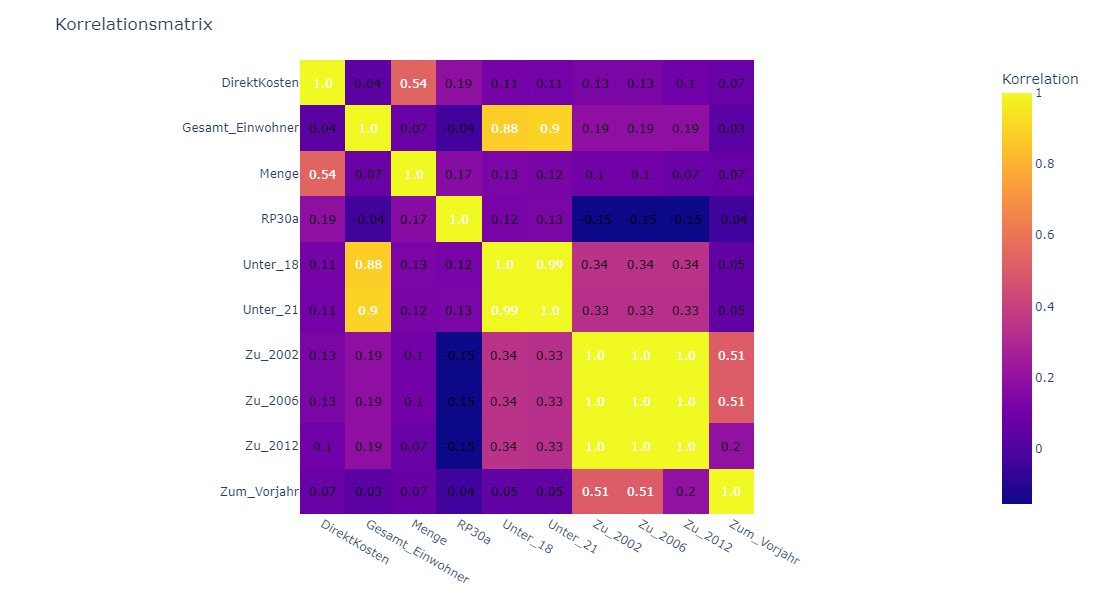

In [ ]:
print('Die Matrix zeigt die jeweiligen linearen Korrelationen zwischen den numerischen Variablen auf Basis des Pearson Koeffizients, wobei eine Nähe zu dem Wert 1 oder -1 eine starke Korrelation bedeutet.')

# Korrelationsmatrix (nur für numerische Spalten, jedoch nicht für den Bezirk und das Jahr)

exclude_columns = ['Bezirk', 'Bezirk_Name', 'Jahr','AggEbene']
numeric_columns_df = df.select_dtypes(include=['int64', 'float64']).columns.difference(exclude_columns)

# Überprüfen, ob es mindestens eine numerische Spalte gibt
if len(numeric_columns_df) > 0:
    # Berechnen der Korrelationsmatrix für numerische Spalten
    corr_matrix = df[numeric_columns_df].corr()
    
    # Plot der interaktiven Korrelationsmatrix mit plotly
    fig = px.imshow(corr_matrix, labels=dict(color="Korrelation"), x=corr_matrix.index, y=corr_matrix.columns)
    
    # Hinzufügen der Korrelationskoeffizienten als Annotations
    annotations = []
    for i, row in enumerate(corr_matrix.index):
        for j, col in enumerate(corr_matrix.columns):
            annotations.append(dict(text=str(round(corr_matrix.iloc[i, j], 2)),
                                    x=col, y=row,
                                    xref='x1', yref='y1',
                                    font=dict(color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black'),
                                    showarrow=False))
    fig.update_layout(title="Korrelationsmatrix", width=800, height=600, annotations=annotations)
    fig.show()

### Vermutete Korrelationen:

Wie bereits vermutet, weisen die folgenden Merkmale keine starke Korrelation mit dem Label auf (Korrelation nahe 0):

- Gesamt_Einwohner
- Pauschale Entwicklung zwischen zwei aufeinanderfolgenden Jahren (Zum_Vorjahr)

Am stärksten korreliert lediglich das Feature 'Menge' (0.54), während  folgende Merkmale eine gewisse Korrelation aufweisen:

- Anteil der MUK (RP30a)
- Unter_18
- Unter_21
- Pauschale Entwicklung (Zu_2002, Zu_2006, Zu_2012)

Die Vermutung liegt nahe, dass diese Features am besten für das spätere Model Training geeignet sind.

Die obige Matrix lässt eine erste Beurteilung der Signifikanz der Attribute zu.

Nachdem wir die Koorelation zwischen allen numerischen Variablen und der Zielvariable gemessen haben, ist es jetzt Zeit anhand der ANOVA-Test zu überprüfen, ob die Zielvariable je nach den Ausprägungen der kategorischen Variablen variiert.

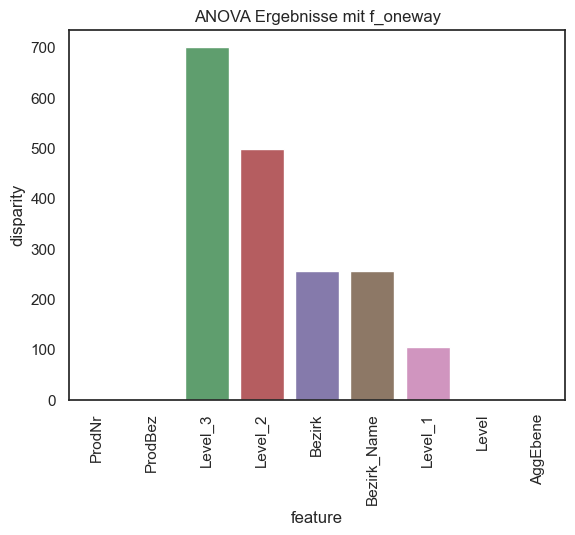

In [ ]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = category_col
    pvals = []
    for c in category_col:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['DirektKosten'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(df)
a['disparity'] = np.log(1./a['pval'].values)
ax = sns.barplot(data=a, x='feature', y='disparity')
ax.set_title('ANOVA Ergebnisse mit f_oneway')
plt.xticks(rotation=90)
plt.show()

Hier ist eine schnelle Abschätzung des Einflusses einer kategorischen Variablen auf den Direktkosten. Für jede Variable werden die Direktkosten in verschiedene Gruppen basierend auf den Kategoriewerten aufgeteilt. Dann wird mit dem ANOVA-Test überprüft, ob die Gruppen ähnliche Verteilungen haben. Wenn eine Variable einen geringen Einfluss hat, sollten die Mittelwerte der Gruppen gleich sein. Ein abnehmender p-Wert deutet auf eine zunehmende Vielfalt in den Gruppierungen hin.

Aus der Grafik kann man entnehmen, dass die wichtigsten Variablen nach Rangfolge 'Level_3,Level_2,Bezirk und Level_1' sind.

In [ ]:
# Bestimmte Spalten auswählen
selected_columns = ['Bezirk_Name', 'Level_1', 'Level_2', 'Level_3', 'ProdNr', 'DirektKosten','Level']

# Neue DataFrame mit ausgewählten Spalten erstellen
new_df = df.loc[:, selected_columns]
# Formel für ANOVA-Syntax erstellen
formula = 'DirektKosten ~ C(Bezirk_Name) + C(Level_1) + C(Level_2) + C(Level_3) + C(ProdNr)+ C(Level)'

# ANOVA durchführen
model = ols(formula, data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# ANOVA-Ergebnisse anzeigen
print("ANOVA Ergebnisse mit ols:")
print(anova_table)

ANOVA Ergebnisse mit ols:
                             sum_sq       df      F  PR(>F)
C(Bezirk_Name)  3173828156166741.00    11.00 186.36    0.00
C(Level_1)       125411635057767.42     2.00  40.50    0.00
C(Level_2)      1693518456691215.25     4.00 273.46    0.00
C(Level_3)       425017007118905.94     3.00  91.50    0.00
C(ProdNr)      42879966187305752.00    44.00 629.45    0.00
C(Level)                       0.00     2.00   0.00    1.00
Residual       15962531628900944.00 10310.00    NaN     NaN


Die ANOVA-Ergebnisse zeigen, dass die Variable "Bezirk,"Level_1, Level_2, Level_3, ProdNr" signifikant mit der abhängigen Variable "DirektKosten" zusammenhängt, da der p-Wert kleiner als 0.05 ist (PR(>F) = 0.00). Dies bedeutet, dass zumindest eine der kategorien dieser Variablen einen signifikanten Einfluss auf die Direktkosten hat.

Der Variable "Level" scheint jedoch keine signifikanten Effekte auf die Direktkosten zu haben, da ihre p-Werte größer als 0.05 sind, was darauf hindeutet, dass sie nicht signifikant sind.

Jetzt schauen wir uns die Korrelation zwischen alle Variablen nochmals an, aber diesmal mit der Spearman-Korrelation.Spearman-Korrelation ist in diesem Fall besser geeignet, da sie Beziehungen zwischen Variablen auch dann erfasst, wenn sie nichtlinear sind. Die ProdNr/ProdBez ist das Hauptkriterium zur Bestimmung der Direktkosten. Die Menge hat auch einen großen Einfluss.

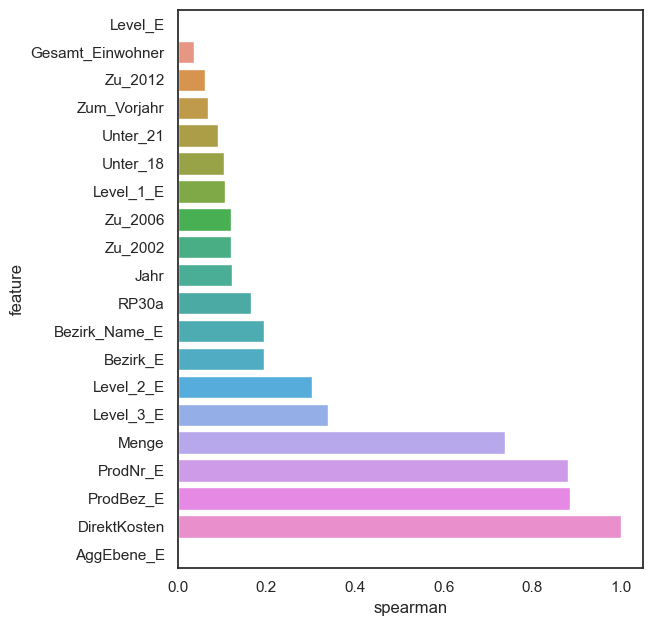

In [ ]:

def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['DirektKosten'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
# Konvertiere Index-Objekte in DataFrame-Objekte
numeric_columns = df_proceed.select_dtypes(include=['int64', 'float64'])
cat_encoded = pd.DataFrame(cat_encoded, columns=['cat_encoded'])

# Extrahiere die Spaltennamen aus den DataFrame-Objekten
numeric_features = numeric_columns.columns.tolist()
cat_features = cat_encoded['cat_encoded'].tolist()

# Kombiniere die beiden Listen von Spaltennamen
#features = numeric_features + cat_features
features = numeric_features+cat_features

# Führe die spearman-Funktion aus
spearman(df_proceed, features)

Nach der Kodierung der kategorischen Variablen in numerischen Variablen erscheint nun "ProdNr/ProdBez" in der Liste der bedeutendsten Variablen, obwohl sie nach der vorherigen Methode als nicht signifikant eingestuft wurde.

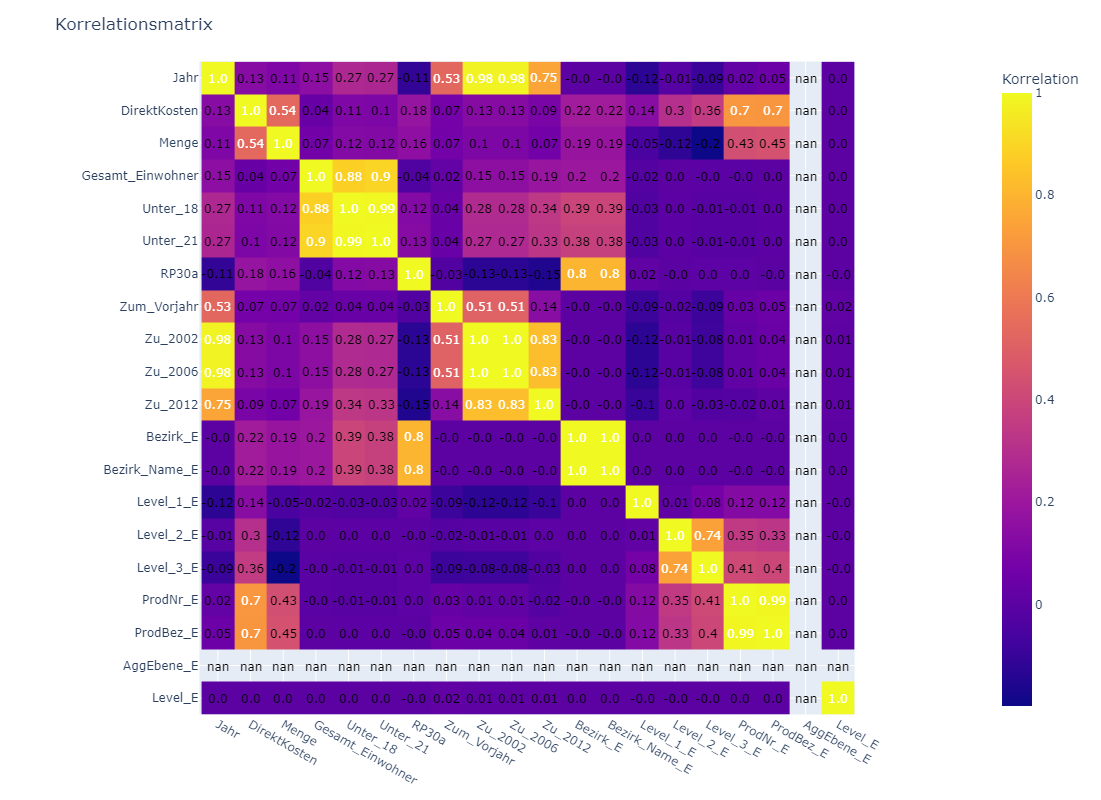

In [ ]:

corr_matrix = df_proceed.corr()

# Plot der interaktiven Korrelationsmatrix mit plotly
fig = px.imshow(corr_matrix, labels=dict(color="Korrelation"), x=corr_matrix.index, y=corr_matrix.columns)

# Hinzufügen der Korrelationskoeffizienten als Annotations
annotations = []
for i, row in enumerate(corr_matrix.index):
    for j, col in enumerate(corr_matrix.columns):
        annotations.append(dict(text=str(round(corr_matrix.iloc[i, j], 2)),
                                x=col, y=row,
                                xref='x1', yref='y1',
                                font=dict(color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black'),
                                showarrow=False))
fig.update_layout(title="Korrelationsmatrix", width=1000, height=800, annotations=annotations)
fig.show()


Es gibt viele starke Korrelationen zwischen den Variablen. Generell sollten nur Variablen, die nicht miteinander korreliert sind (aber mit den Direktkosten korreliert sind), später bei der Modellierung zu Modellen hinzugefügt werden, um Verwechslungen zu reduzieren.

Es wäre auch nützlich zu sehen, wie sich die Direktkosten zu jeder unabhängigen Variable verhält.

## Pairplots

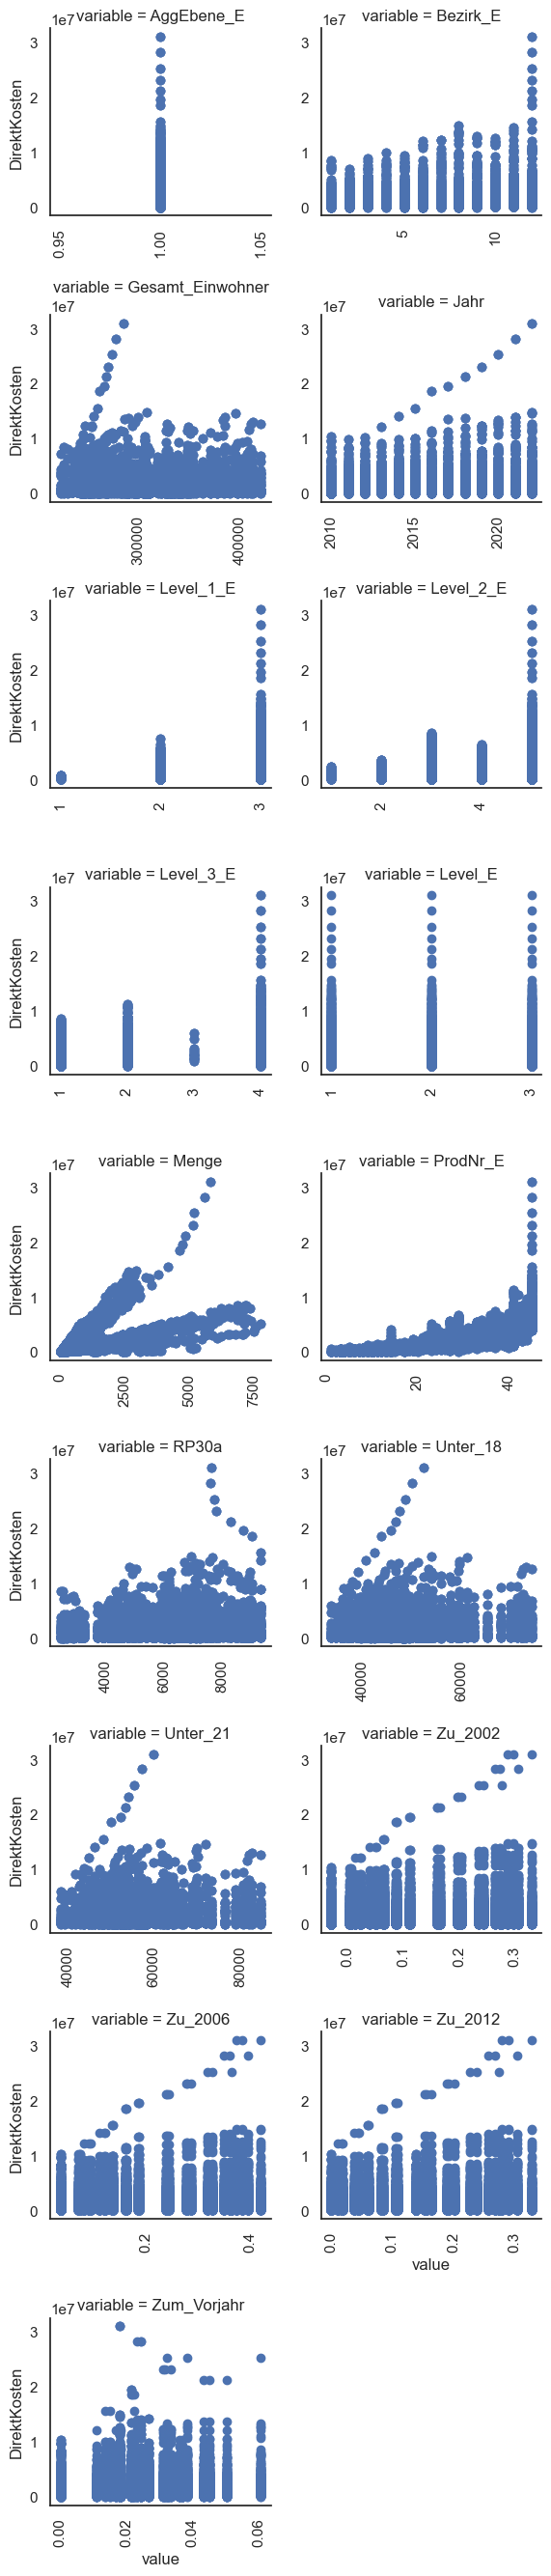

In [ ]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ax.scatter(x, y, **kwargs)
    plt.xticks(rotation=90)

exclude_columns = ['Bezirk_Name_E','ProdBez_E']
f = pd.melt(df_proceed, id_vars=['DirektKosten'], value_vars=df_proceed.columns.difference(exclude_columns))
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False)
g = g.map(pairplot, "value", "DirektKosten")

# Feature Selection

Um eine möglichst optimale Anzahl an repräsentativen Attributen bzw. Features zu erhalten, werden wir unterschiedliche statistische Selektionsmethode ausprobieren:

## 1) Feature selection mit Korrelation und Random Forest Regressor

Wie in der Heatmap oben zu sehen ist, sind Jahr,Zu_2002,Zu_2006 und Zu_2012 miteinander korreliert, so dass wir nur Jahr verwenden werden. Lassen Sie uns also andere korrelierte Merkmale finden und die MSE mit dem Random Forest Regressor  überprüfen.
Gesamt_Einwohner, Unter_18 und Unter_21  sind miteinander korreliert, daher wählen wir nur Unter_18. Abgesehen davon sind Bezirk_E und Bezirk_Name_E korreliert und wir verwenden nur Bezirk_E. ProdNr_E und ProdBez_E sind korreliert und wir verwenden ProdNr_E. Bezirk_E, Bezirk_Name_E und RP30a korrelieren und wir verwenden Bezirk_E. Level_2_E und Level_3_E korrelieren und wir verwenden Level_3_E. Wir werden auch auf AggEbene_E und Level_E, da sie gar keine Korrelation zur Zielvariable haben.

In [ ]:
drop_list1 = ['Zu_2002','Zu_2006','Zu_2012','Gesamt_Einwohner','Unter_21','Bezirk_Name_E','ProdBez_E','AggEbene_E','Level_E','Level_2_E','RP30a']
df_proceed_1 = df_proceed.drop(drop_list1,axis = 1 )         
df_proceed_1.head()

Jahr  DirektKosten  Menge  Unter_18  Zum_Vorjahr  Bezirk_E  Level_1_E  \
0  2010    1113989.75   2739  48301.08         0.00     11.00       2.00   
1  2010    1113989.75   2739  48301.08         0.00     11.00       2.00   
2  2010    1113989.75   2739  48301.08         0.00     11.00       2.00   
3  2010    4903672.91   1318  48301.08         0.00     11.00       2.00   
4  2010    4903672.91   1318  48301.08         0.00     11.00       2.00   

   Level_3_E  ProdNr_E  
0       1.00     23.00  
1       1.00     23.00  
2       1.00     23.00  
3       3.00     34.00  
4       3.00     34.00

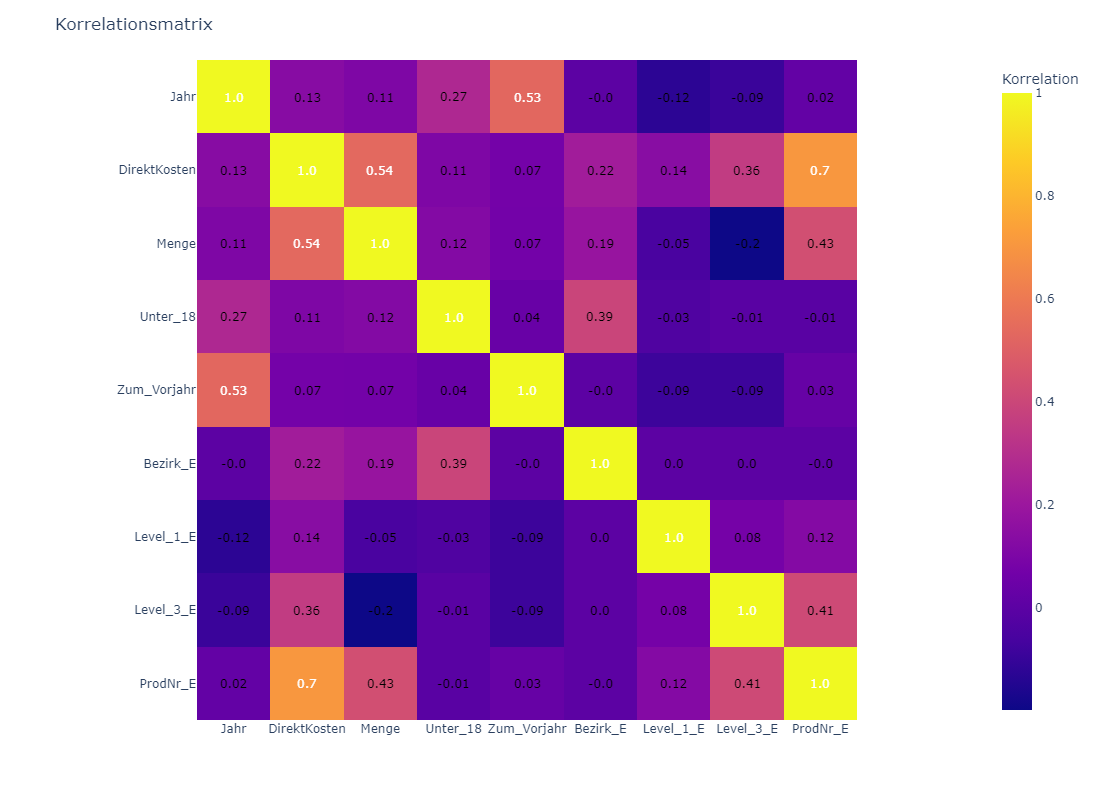

In [ ]:
#correlation map

corr_matrix = df_proceed_1.corr()

# Plot der interaktiven Korrelationsmatrix mit plotly
fig = px.imshow(corr_matrix, labels=dict(color="Korrelation"), x=corr_matrix.index, y=corr_matrix.columns)

# Hinzufügen der Korrelationskoeffizienten als Annotations
annotations = []
for i, row in enumerate(corr_matrix.index):
    for j, col in enumerate(corr_matrix.columns):
        annotations.append(dict(text=str(round(corr_matrix.iloc[i, j], 2)),
                                    x=col, y=row,
                                    xref='x1', yref='y1',
                                    font=dict(color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black'),
                                    showarrow=False))
fig.update_layout(title="Korrelationsmatrix", width=1000, height=800, annotations=annotations)
fig.show()

Nun, wir haben unsere Merkmale ausgewählt, aber haben wir richtig gewählt? Verwenden wir Random Forest und finden wir die MSE entsprechend der gewählten Merkmale.

In [ ]:
# Aufteilen der Daten in Features (X) und Zielvariable (y)
y = df_proceed_1.DirektKosten  # Features ohne die Zielvariable
list = ['DirektKosten']
x = df_proceed_1.drop(list,axis = 1 )  # Features ohne die Zielvariable
x.head()


Jahr  Menge  Unter_18  Zum_Vorjahr  Bezirk_E  Level_1_E  Level_3_E  \
0  2010   2739  48301.08         0.00     11.00       2.00       1.00   
1  2010   2739  48301.08         0.00     11.00       2.00       1.00   
2  2010   2739  48301.08         0.00     11.00       2.00       1.00   
3  2010   1318  48301.08         0.00     11.00       2.00       3.00   
4  2010   1318  48301.08         0.00     11.00       2.00       3.00   

   ProdNr_E  
0     23.00  
1     23.00  
2     23.00  
3     34.00  
4     34.00

In [ ]:
# Aufteilen der Daten in Trainings- und Testsets (train 70 % and test 30 %)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Standardisierung der Daten
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Random Forest Regressor initialisieren und trainieren
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(x_train_scaled, y_train)

# Vorhersagen machen
y_pred = rf_regressor.predict(x_test_scaled)

# Berechnen der Modellleistung
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

# Merkmalswichtigkeiten anzeigen
feature_importances = rf_regressor.feature_importances_
print("Feature Importances:", feature_importances)

# Erstellen eines DataFrames mit Merkmalen und ihren Wichtigkeiten
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})

# Sortieren des DataFrames nach Wichtigkeit absteigend
importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False)

# Anzeigen der sortierten Feature-Importances
print(importance_df_sorted)


Mean Squared Error: 9362202195.85097
R-squared: 0.9984327603405522
Feature Importances: [0.02120691 0.23565188 0.00655927 0.00159884 0.0255858  0.00446211
 0.01275692 0.69217826]
       Feature  Importance
7     ProdNr_E        0.69
1        Menge        0.24
4     Bezirk_E        0.03
0         Jahr        0.02
6    Level_3_E        0.01
2     Unter_18        0.01
5    Level_1_E        0.00
3  Zum_Vorjahr        0.00


Der **mittlere quadratische Fehler (Mean Squared Error, MSE)** beträgt 9241547874.446463. Dieser Wert misst die durchschnittliche quadratische Abweichung zwischen den tatsächlichen und den vorhergesagten Werten. Ein niedrigerer MSE deutet auf eine bessere Passform des Modells hin. Da die Zielvariable in Millionen gemessen wird, ist ein MSE von 9,24 Milliarden Quadratmillionen vielleicht nicht unbedingt als gut zu betrachten. Es deutet darauf hin, dass das Modell große Abweichungen in den Vorhersagen aufweist und keine gute Leistung erzielt.

Der **R²-Wert (R-squared)** beträgt etwa 0,998. Dieser Wert gibt an, wie gut die unabhängigen Variablen die abhängige Variable erklären. R² liegt zwischen 0 und 1, wobei 1 darauf hinweist, dass das Modell perfekt zu den Daten passt, und 0 darauf hinweist, dass das Modell keine Varianz in den Daten erklärt. Ein R²-Wert nahe 1 deutet darauf hin, dass das Modell die Variation der Zielvariable gut erklärt.

Insgesamt zeigen diese Metriken, dass das Regressionsmodell nicht so gut zu den Testdaten passt, aber eine hohe Erklärungskraft für die abhängige Variable aufweist.

Wir sind noch nicht an dem Punkt, an dem wir ein Modell haben wollen, das die direkten Kosten angemessen vorhersagen kann. Aus diesem Grund werden wir keine Ansätze zur Verbesserung des Modells in Betracht ziehen, aber wir werden dies zu einem späteren Zeitpunkt tun.

Die **Feature Importances** geben an, wie wichtig jedes Merkmal (Feature) für die Vorhersagen des Modells ist. Hier ist eine Interpretation der Feature-Importances-Werte:

- Jahr: Dieses Merkmal hat eine relative Wichtigkeit von etwa 2,12%. Es scheint also das am wenigsten wichtige Merkmal für das Modell zu sein.
- Menge: Mit einem Beitrag von ungefähr 23,56% zur Gesamtbedeutung ist dieses Merkmal das zweitwichtigste im Modell. Es hat eine relativ hohe Wichtigkeit und trägt wesentlich zur Vorhersageleistung bei.
- Unter_18: Die relative Wichtigkeit dieses Merkmals beträgt etwa 0,65%. Es trägt also vergleichsweise wenig zur Vorhersageleistung bei und ist relativ unbedeutend.
- Zum_Vorjahr: Dieses Merkmal hat eine sehr niedrige relative Wichtigkeit von etwa 0,15%, was darauf hindeutet, dass es nur einen geringen Einfluss auf die Vorhersagen hat.
- Bezirk: Mit einem Anteil von etwa 2,56% trägt dieses Merkmal etwas mehr zur Vorhersageleistung bei, aber immer noch relativ wenig im Vergleich zu anderen Merkmalen.
- Level_1: Die relative Wichtigkeit dieses Merkmals beträgt etwa 0,45%, was darauf hinweist, dass es einen relativ geringen Einfluss auf die Vorhersagen hat.
- Level_3: Dieses Merkmal hat eine relative Wichtigkeit von etwa 1,28% und trägt vergleichsweise wenig zur Vorhersageleistung bei.
- ProdNr: Mit einem Anteil von etwa 69,22% ist dieses Merkmal das mit Abstand wichtigste im Modell. Es hat einen sehr hohen Einfluss auf die Vorhersagen und ist entscheidend für die Leistung des Modells.

## 2) Univariate feature selection and Random Forest Regressor

Bei der univariaten Merkmalsauswahl verwenden wir SelectKBest, das alle Merkmale bis auf die k (hier 5) am höchsten bewerteten ausschließt

In [ ]:
# Aufteilen der Daten in Features (X) und Zielvariable (y)
y_kbest = y
x_kbest = x
x_kbest.head()


Jahr  Menge  Unter_18  Zum_Vorjahr  Bezirk_E  Level_1_E  Level_3_E  \
0  2010   2739  48301.08         0.00     11.00       2.00       1.00   
1  2010   2739  48301.08         0.00     11.00       2.00       1.00   
2  2010   2739  48301.08         0.00     11.00       2.00       1.00   
3  2010   1318  48301.08         0.00     11.00       2.00       3.00   
4  2010   1318  48301.08         0.00     11.00       2.00       3.00   

   ProdNr_E  
0     23.00  
1     23.00  
2     23.00  
3     34.00  
4     34.00

In [ ]:

# Aufteilen der Daten in Trainings- und Testsets (train 70 % and test 30 %)
x_kbest_train, x_kbest_test, y_kbest_train, y_kbest_test = train_test_split(x_kbest, y_kbest, test_size=0.3, random_state=42)


# Standardisierung der Daten
scaler = StandardScaler()
x_kbest_train_scaled = scaler.fit_transform(x_kbest_train)
x_kbest_test_scaled = scaler.transform(x_kbest_test)

# Initialisierung und Anpassung von SelectKBest mit f_regression
select_feature = SelectKBest(score_func=f_regression, k=5)
select_feature.fit(x_kbest_train_scaled, y_kbest_train)

# Drucken der Merkmalsbewertungen
print('Score list:', select_feature.scores_)

# Index der ausgewählten Merkmale
selected_feature_indices = select_feature.get_support(indices=True)

# Namen der ausgewählten Merkmale erhalten
selected_feature_names = x_kbest_train.columns[selected_feature_indices]

# Drucken der Namen der ausgewählten Merkmale
print('Selected feature list:', selected_feature_names)


#
#print("Selected features shape:", x_kbest_train_selected.shape)

Score list: [ 159.48237414 2865.31922413  111.43448356   50.68247828  374.21666337
  147.03898052 1041.18547348 7170.30670633]
Selected feature list: Index(['Jahr', 'Menge', 'Bezirk_E', 'Level_3_E', 'ProdNr_E'], dtype='object')


Die **Score list** zeigt die Bewertungen der Merkmale basierend auf der f_regression-Bewertungsfunktion. Diese Bewertungen geben an, wie stark jedes Merkmal mit der Zielvariable korreliert ist. Hier ist eine Interpretation der ausgewählten Merkmale:

- **ProdBez_E:** Dieses Merkmal hat die höchste Bewertung von 7170.31. Das deutet darauf hin, dass es einen starken Zusammenhang zwischen der Menge und der Zielvariable gibt. Ein höherer Wert in diesem Merkmal geht wahrscheinlich mit höheren Zielvariablenwerten einher.

- **Menge:** Dieses Merkmal hat eine Bewertung von 2865.32, was darauf hinweist, dass es auch einen signifikanten Einfluss auf die Zielvariable hat, aber nicht so stark wie die ProdBez_E.

- **Level_3_E:**  dieses Merkmal hat eine Bewertung von 1041.19. Es scheint also eine ähnliche Wichtigkeit für die Vorhersagen zu haben.

- **Bezirk_E:** Mit einer Bewertung von 374.22 trägt dieses Merkmal auch erheblich zur Vorhersageleistung bei.
 
- **Jahr:** Dieses Merkmal hat eine Bewertung von 159.48, was darauf hinweist, dass es einen starken Einfluss auf die Zielvariable hat.
  
- **Level_1_E:** Dieses Merkmal hat eine Bewertung von 147.04, was darauf hinweist, dass es einen schwachen Einfluss auf die Zielvariable hat.
  
- **Unter_18:** Dieses Merkmal hat eine Bewertung von 111.44, was darauf hinweist, dass es einen schwachen Einfluss auf die Zielvariable hat.

- **Zum_Vorjahr:** Dieses Merkmal hat eine Bewertung von 50.68, was darauf hinweist, dass es einen schwachen Einfluss auf die Zielvariable hat.

Die **Selected feature list** repräsentieren diejenigen, die am stärksten mit der Zielvariable korrelieren und daher als die relevantesten für die Vorhersagen angesehen werden. In diesem Fall scheinen insbesondere die Produktbezeichnung; die Menge, die dritte Ebene der Produkte,der Bezirk und das Jahr wichtige Prädiktoren für die Zielvariable zu sein.

## 3) Recursive feature elimination mit Krossvalidierung (RFECV)

Grundsätzlich wird eine der Regressionssmethoden (in unserem Beispiel Random Forest) verwendet und jedem Merkmal eine Gewichtung zugewiesen. Die Merkmale, deren absolute Gewichtung am kleinsten ist, werden aus dem aktuellen Satz von Merkmalen gestrichen. Diese Prozedur wird rekursiv auf der beschnittenen Menge wiederholt.Jetzt werden wir nicht nur die besten Merkmale finden, sondern auch herausfinden, wie viele Merkmale wir für die beste MSE benötigen.

In [ ]:
# Random Forest Regressor initialisieren
rf_regressor_1 = RandomForestRegressor()

# RFECV anwenden
rfecv = RFECV(estimator=rf_regressor_1, step=1, cv=5, scoring='neg_mean_squared_error')  # 5-fold cross-validation
rfecv.fit(x_kbest_train, y_kbest_train)

print('Optimale Anzahl der Merkmale:', rfecv.n_features_)
print('Beste Merkmale:', x_kbest_train.columns[rfecv.support_])

Optimale Anzahl der Merkmale: 7
Beste Merkmale: Index(['Jahr', 'Menge', 'Unter_18', 'Bezirk_E', 'Level_1_E', 'Level_3_E',
       'ProdNr_E'],
      dtype='object')


## Time Lag Analysis

nous souhaitons calculer chaque variable indépendante continue avec un shift (retard) par la fonction shift() afin de comparer la corrélation avec les autres variables.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
 'DirektKosten','Menge','Gesamt_Einwohner','Unter_18','Unter_21','RP30a','Zum_Vorjahr','Zu_2002','Zu_2006','Zu_2012'
]

for column in core_columns:
    decomp = seasonal_decompose(df_proceed[column], period=10, model='additive', extrapolate_trend='freq')
    df_proceed[f"{column}_trend"] = decomp.trend
    df_proceed[f"{column}_seasonal"] = decomp.seasonal


fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['Menge', 'Gesamt_Einwohner']):
    res = seasonal_decompose(df[column], period=10, model='additive', extrapolate_trend='freq')
    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)
    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)
    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Nehmen wir an, df_proceed ist Ihr DataFrame und Sie haben alle benötigten Variablen darin.

core_columns =  [
 'DirektKosten','Menge','Gesamt_Einwohner','Unter_18','Unter_21','RP30a','Zum_Vorjahr','Zu_2002','Zu_2006','Zu_2012'
]

# Durchführung der saisonalen Zerlegung für jede Variable in core_columns
for column in core_columns:
    decomp = seasonal_decompose(df_proceed[column], period=10, model='additive', extrapolate_trend='freq')
    df_proceed[f"{column}_trend"] = decomp.trend
    df_proceed[f"{column}_seasonal"] = decomp.seasonal

# Visualisierung der saisonalen Zerlegung für ausgewählte Variablen
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['Menge', 'Gesamt_Einwohner']):
    res = seasonal_decompose(df_proceed[column], period=10, model='additive', extrapolate_trend='freq')
    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)
    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)
    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()


NameError: name 'df_proceed' is not defined

Diese Visualisierungen können hilfreich sein, um saisonale Muster und Trends in den ausgewählten Spalten zu identifizieren und zu verstehen. Sie können auch dazu beitragen, potenzielle saisonale Effekte bei der Modellierung und Vorhersage zu berücksichtigen.

In [3]:
df_proceed.Level_1

NameError: name 'df_proceed' is not defined

In [ ]:
years_in_advance = 1  # Anzahl der Jahre, um die die Daten verschoben werden sollen

# Umrechnung von Jahren in Monate
months_in_year = years_in_advance * 12

# Erstellen der neuen Spalten mit der Verschiebung um Jahre

#for column in core_columns:
#    df[f'{column}_seasonal_shift_1y'] = df[f'{column}_seasonal'].shift(1 * months_in_year)
#    df[f'{column}_seasonal_shift_2y'] = df[f'{column}_seasonal'].shift(2 * months_in_year)
#    df[f'{column}_seasonal_shift_3y'] = df[f'{column}_seasonal'].shift(3 * months_in_year)

In [ ]:
#f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

#corrmat = df[core_columns].corr()

#sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
#ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

#shifted_cols = [
#    'DirektKosten_seasonal',         
 #   'Menge_seasonal_shift_3m',
#    'Gesamt_Einwohner_seasonal_shift_2m', 
#    'Unter_18_seasonal_shift_2m'
#]
#corrmat = df[shifted_cols].corr()

#sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
#ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


#plt.tight_layout()
#plt.show()

###  Verbindung zur Datenbank schließen

In [ ]:
#conn.close()
